# Tutorial for use of the 'ts_helpers' modeling scripts

- For questions/bugs, reach out to Jarred Bultema, Jess Lin, or Jay Schuren for assistance

In [1]:
# change this setting so you don't get memory efforts if you generate a lot of plots/figures in this notebook
# if your default 'ulimit -n' returns something like '256', then you will get memory errors that prevent saving the notebook

# increase the limit, and minimize risk. Do this here or right after you start the Jupyter lab/notebook kernel directly in the terminal
! ulimit -n 4096

In [2]:
# import packages
import datarobot as dr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pandas.tseries.offsets import MonthEnd
import os
import re 
import glob
from importlib import reload
import plotly.express as px
import plotly.graph_objects as go
import time
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# set pandas configuration to show all columns
pd.set_option('display.max_columns', None)

In [4]:
# configure connection to DataRobot
# endpoint and API-token are stored in a config file

# US-server
dr.Client(config_path='/Users/jarred.bultema/.config/datarobot/drconfig.yaml', connect_timeout= 50000)

# staging
# dr.Client(config_path='/Users/jarred.bultema/.config/datarobot/drconfig_staging.yaml', connect_timeout= 50000)

In [5]:
# TS helper scripts are copied into the 'src' folder
# src-folder is at the same level in the directory as this notebook
%load_ext autoreload
%autoreload 2
from src.ts_projects import *
from src.ts_pre_processing import *
from src.ts_predictions import *
from src.ts_modeling import *
from src.ts_metrics import *
from src.ts_data_quality import *
from src.ts_clustering import *
from src.ts_calendar import *
from src.ts_data_preparation import *

In [9]:
test = dr.Project.list()[40]

In [19]:
data = dr.Dataset.list()

In [ ]:
data

-----
# Data Prep - 
        'Nigeria', 'Morocco', 'South Africa', 'Algeria', 'Ghana',
       'Djibouti', 'Cameroon', 'Gabon', 'Germany', 'Greece', 'Spain',
       'Italy', 'France', 'Egypt', 'Israel', 'UnitedKingdom'

## The following data-prep pipeline was set up for COVID modeling for Africa, and is completely separate from COVID-machine data and pipelines. You can ignore this stuff below:

In [9]:
def create_daily(df, series_id, column_id, new_col_name):
    output = pd.DataFrame()
    for series in df[series_id].unique():
        data = df[df[series_id] == series].copy()
        data[new_col_name] = data[column_id].astype(float).diff(periods= 1).fillna(0)
        output = output.append(data)
    return output

def aggregate_demo_data(path, year, n):
    output = pd.DataFrame()
    glob.glob(path)
    for file in glob.glob(path):
        try:
            df = pd.read_csv(file, header= 2)
            
            # get latest values and percent growth over n years
            indicator = df['Indicator Name'].unique()[0]
            df[f'Latest_{indicator.replace(", ","_")}'] = df[year]
            df[f'{n}_year_percent_change_{indicator.replace(", ","_")}'] = ((df[year] - df[str(int(year)-n)])/ df[str(int(year)-n)]) * 100
            df = df[['Country Name', 'Country Code', f'Latest_{indicator.replace(", ","_")}', f'{n}_year_percent_change_{indicator.replace(", ","_")}']].copy()

            if output.shape[0] == 0:
                output = df.copy()
            else:
                output = pd.concat((output,df[[f'Latest_{indicator.replace(", ","_")}', f'{n}_year_percent_change_{indicator.replace(", ","_")}']]), axis= 1)
        except:
            print(f'{file} could not be used')
    return output

def days_since(df, date_col, series_col, target, n):

    for series in df[series_col].unique().tolist():
        try:
            data = df[(df[series_col] == series)]
            first_date = df[(df[series_col] == series) & (df[target] >= n)]['Date'].min()
#             first_idx = df[(df[series_col] == series) & (df[target] >= n)].index.min()

            if first_date == np.nan:
                df[f'Time_since_{n}_cases'] = 0
                continue
            else:
                df['first_date'] = first_date
                df[date_col] = pd.to_datetime(df[date_col])
                df[f'Time_since_{n}_{target}_cases'] = df[date_col] - df['first_date']
                df[f'Time_since_{n}_{target}_cases'] = df[f'Time_since_{n}_{target}_cases']/np.timedelta64(1,'D')
                df[f'Time_since_{n}_{target}_cases'] = df[f'Time_since_{n}_{target}_cases'].apply(lambda x: [v if v > 0 else 0 for v in [x]][0])
                df.drop('first_date', axis= 1, inplace= True)
        except: 
            print('Couldn\'t find an appropriate timeset for first occurence')
    return df

def find_fill_missing_dates_nan(df, aggregator, date_col):
    '''
    Identifies missing dates, fills missing dates with NaN
    ----
    inputs: Pandas DataFrame, aggregation column (string)
    outputs: Pandas DataFrame
    '''
    new_df = pd.DataFrame([])
    for item in df[aggregator].unique().tolist():
        data = df[df[aggregator] == item]
        s = data[date_col].min()
        e = data[date_col].max()
        missing_dates = pd.DataFrame(pd.date_range(start = s, end = e).difference(data[date_col]), columns = ['Date'])
        missing_dates[aggregator] = item
        data = data.append(missing_dates)
        new_df = new_df.append(data)
    return new_df

In [10]:
# get updated JHU data
covid_cases = pd.read_csv('data/JHU_data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid_deaths = pd.read_csv('data/JHU_data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
covid_cases.drop(['Lat', 'Long'], axis=1, inplace= True)
covid_deaths.drop(['Lat', 'Long'], axis=1, inplace= True)

# change format
covid_cases = pd.melt(covid_cases, id_vars= ['Country/Region', 'Province/State'], var_name= 'Date', value_name= 'Cumulative_cases')
covid_deaths = pd.melt(covid_deaths, id_vars= ['Country/Region', 'Province/State'], var_name= 'Date', value_name= 'Cumulative_deaths')

# aggregate and perform calculations
covid_cases = create_daily(covid_cases, 'Country/Region', 'Cumulative_cases', 'Daily_cases')
covid_deaths = create_daily(covid_deaths, 'Country/Region', 'Cumulative_deaths', 'Daily_deaths')
covid_deaths.drop('Province/State', axis= 1, inplace= True)
covid = covid_cases.merge(covid_deaths, on= ['Country/Region', 'Date'], how= 'outer')
covid = covid.groupby(['Country/Region', 'Date']).sum().reset_index()
covid['DataLevel'] = 'Country/Region'
covid['Date'] = pd.to_datetime(covid['Date'])
df = covid[['Country/Region', 'Date', 'DataLevel', 'Cumulative_cases', 'Daily_cases', 'Cumulative_deaths', 'Daily_deaths']]

In [11]:
# google global mobility data
global_mobility = pd.read_csv('data/Global_Mobility_Report (1).csv')
global_mobility.drop(['sub_region_1', 'sub_region_2', 'iso_3166_2_code', 'census_fips_code'], axis= 1, inplace= True)
global_mobility['date'] = pd.to_datetime(global_mobility['date'])

# aggregate the sub-country regions into the country-level
global_mobility = global_mobility.groupby(['date', 'country_region']).sum().reset_index()

# demographic data for Africa
demo_data = aggregate_demo_data(path = 'data/bulk_demo_data/*', year = '2018', n= 5)

# additional economic data on countries
econ = pd.read_csv('data/Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_1120881.csv')
# remap country cat to int
ranks = dict(zip(econ['IncomeGroup'].value_counts().index.tolist()[::-1], [idx for idx,x in enumerate(econ['IncomeGroup'].unique().tolist(), 1)]))
econ['IncomeGroup_rank'] = econ['IncomeGroup'].map(ranks)

# democracy score data for countries
democracy = pd.read_excel('data/African Country Holidays & World Democracy Scores.xlsx', sheet_name= 'DemocracyScore')
democracy['Country'] = democracy['Country'].apply(lambda x: x.replace('\xa0',''))

In [12]:
# find and add missing dates
df = find_fill_missing_dates_nan(df, 'Country/Region', 'Date')

# calculate days since
covid = days_since(df, date_col = 'Date', series_col = 'Country/Region', target = 'Daily_cases', n = 1)
covid = days_since(covid, date_col = 'Date', series_col = 'Country/Region', target= 'Daily_cases', n = 30)
covid = days_since(covid, date_col = 'Date', series_col = 'Country/Region', target = 'Daily_deaths', n = 1)
covid = days_since(covid, date_col = 'Date', series_col = 'Country/Region', target= 'Daily_deaths', n = 30)
covid = days_since(covid, date_col = 'Date', series_col = 'Country/Region', target = 'Cumulative_cases', n = 1)
covid = days_since(covid, date_col = 'Date', series_col = 'Country/Region', target= 'Cumulative_cases', n = 30)
covid = days_since(covid, date_col = 'Date', series_col = 'Country/Region', target = 'Cumulative_deaths', n = 1)
covid = days_since(covid, date_col = 'Date', series_col = 'Country/Region', target= 'Cumulative_deaths', n = 30)

covid['Confirmed_cases_change'] = covid['Daily_cases'].pct_change().fillna(0).apply(lambda x: [v if v != np.inf else 1.0 for v in [x]][0])
covid['Cumulative_cases_change'] = covid['Cumulative_cases'].pct_change().fillna(0).apply(lambda x: [v if v != np.inf else 1.0 for v in [x]][0])
covid['Confirmed_deaths_change'] = covid['Daily_deaths'].pct_change().fillna(0).apply(lambda x: [v if v != np.inf else 1.0 for v in [x]][0])
covid['Cumulative_deaths_change'] = covid['Cumulative_deaths'].pct_change().fillna(0).apply(lambda x: [v if v != np.inf else 1.0 for v in [x]][0])

# merge the data together
print(covid.shape)
covid = covid.merge(global_mobility, how= 'left', left_on= ['Country/Region', 'Date'], right_on= ['country_region','date']).drop(['country_region','date'], axis=1)
print(covid.shape)
covid = covid.merge(demo_data, how= 'left', left_on= 'Country/Region', right_on= 'Country Name').drop(['Country Name'], axis= 1)
print(covid.shape)
covid = covid.merge(econ, how= 'left', on= 'Country Code').drop(['Country Code', 'TableName','SpecialNotes','Unnamed: 5'], axis= 1)
print(covid.shape)
covid = covid.merge(democracy, how= 'left', left_on= 'Country/Region', right_on= 'Country').drop('Country', axis= 1)

# fix date formatting
covid['Date'] = pd.to_datetime(covid['Date'])

(31396, 19)
(31396, 25)
(31396, 46)
(31396, 48)


## Here is what our modeling data looks like

In [13]:
covid.head()

Country/Region  Cumulative_cases  Cumulative_deaths  Daily_cases  \
0    Afghanistan               0.0                0.0          0.0   
1    Afghanistan               0.0                0.0          0.0   
2    Afghanistan               0.0                0.0          0.0   
3    Afghanistan               0.0                0.0          0.0   
4    Afghanistan               0.0                0.0          0.0   

   Daily_deaths       DataLevel       Date  Time_since_1_Daily_cases_cases  \
0           0.0  Country/Region 2020-01-22                             0.0   
1           0.0  Country/Region 2020-01-23                             0.0   
2           0.0  Country/Region 2020-01-24                             0.0   
3           0.0  Country/Region 2020-01-25                             0.0   
4           0.0  Country/Region 2020-01-26                             0.0   

   Time_since_30_Daily_cases_cases  Time_since_1_Daily_deaths_cases  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   Time_since_30_Daily_deaths_cases  Time_since_1_Cumulative_cases_cases  \
0                                 0                                  0.0   
1                                 0                                  0.0   
2                                 0                                  0.0   
3                                 0                                  0.0   
4                                 0                                  0.0   

   Time_since_30_Cumulative_cases_cases  Time_since_1_Cumulative_deaths_cases  \
0                                   0.0                                   0.0   
1                                   0.0                                   0.0   
2                                   0.0                                   0.0   
3                                   0.0                                   0.0   
4                                   0.0                                   0.0   

   Time_since_30_Cumulative_deaths_cases  Confirmed_cases_change  \
0                                      0                     0.0   
1                                      0                     0.0   
2                                      0                     0.0   
3                                      0                     0.0   
4                                      0                     0.0   

   Cumulative_cases_change  Confirmed_deaths_change  Cumulative_deaths_change  \
0                      0.0                      0.0                       0.0   
1                      0.0                      0.0                       0.0   
2                      0.0                      0.0                       0.0   
3                      0.0                      0.0                       0.0   
4                      0.0                      0.0                       0.0   

   retail_and_recreation_percent_change_from_baseline  \
0                                                NaN    
1                                                NaN    
2                                                NaN    
3                                                NaN    
4                                                NaN    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

   parks_percent_change_from_baseline  \
0                                 NaN   
1                                 NaN   
2                                 NaN   
3

In [14]:
# save new covid data to file
covid.to_csv('data/JHU_all_enriched_through_July_6.csv', index= None)

In [15]:
# we are only going to use the data from 15 countries to build these projects, but built the pipeline for as many of the countries as currently exist
# some countries are missing certain aspects of the enriched data (google mobility, etc)
desired_series = ['Nigeria', 'Morocco', 'South Africa', 'Algeria', 'Ghana',
   'Djibouti', 'Cameroon', 'Gabon', 'Germany', 'Greece', 'Spain',
   'Italy', 'France', 'Egypt', 'Israel']
covid_all = covid.copy()
covid = covid[covid['Country/Region'].isin(desired_series)]

--------------
# Configuring the DataRobot Projects

## the ts_helper scripts utilize a single ts_settings dictionary where the majority of project settings are set

In [16]:
# set your known-in-advance features in a list
# the feature names need to perfectly match the data, and any KIAs listed here will need to be included in scoring data used later
KIAs = ['DataLevel',
       'Time_since_1_Daily_cases_cases', 'Time_since_30_Daily_cases_cases',
       'Time_since_1_Daily_deaths_cases', 'Time_since_30_Daily_deaths_cases',
       'Time_since_1_Cumulative_cases_cases',
       'Time_since_30_Cumulative_cases_cases',
       'Time_since_1_Cumulative_deaths_cases',
       'Time_since_30_Cumulative_deaths_cases', 
       'Latest_Population_total',
       '5_year_percent_change_Population_total', 'Latest_GDP (current US$)',
       '5_year_percent_change_GDP (current US$)',
       'Latest_GDP growth (annual %)',
       '5_year_percent_change_GDP growth (annual %)',
       'Latest_Population_male (% of total population)',
       '5_year_percent_change_Population_male (% of total population)',
       'Latest_Population ages 65 and above_total',
       '5_year_percent_change_Population ages 65 and above_total',
       'Latest_School enrollment_primary (% gross)',
       '5_year_percent_change_School enrollment_primary (% gross)',
       'Latest_Life expectancy at birth_total (years)',
       '5_year_percent_change_Life expectancy at birth_total (years)',
       'Latest_Population_male', '5_year_percent_change_Population_male',
       'Latest_Population ages 65 and above (% of total population)',
       '5_year_percent_change_Population ages 65 and above (% of total population)',
       'Latest_Population ages 65 and above_male (% of male population)',
       '5_year_percent_change_Population ages 65 and above_male (% of male population)',
       'Region', 'IncomeGroup', 'IncomeGroup_rank', '2019DemocracyScore']


In [17]:
# Set default values
target= 'Daily_cases'
date_col = 'Date'
series_id = 'Country/Region'
kia = KIAs
num_backtests = 3
validation_duration = 7 
holdout_duration = 7 
disable_holdout = False
metric = 'RMSE'
use_time_series = True
# use_cross_series_features = True
fd_start = 1
fd_end = 30 
fdw_start = -14 # 
fdw_end = 0
max_date = covid['Date'].max()

# optional variable that lets you limit the number of workers that will be used for this modeling-stream. 
# This is useful if you'll be running several modeling pipelines separately on shared worker pool. 
# Set to -1 for all workers, or any int for a limited number of workers
# n_workers= -1

# create Time Series settings
ts_settings = {'max_date':max_date, 'known_in_advance':kia, 'num_backtests':num_backtests, 
               'validation_duration':validation_duration, 'holdout_duration':holdout_duration,
               'disable_holdout':disable_holdout,'use_time_series':use_time_series,
               'series_id':series_id, 'metric':metric, 'target':target, 'date_col':date_col,
               'fd_start':fd_start, 'fd_end':fd_end, 'fdw_start':fdw_start, 'fdw_end':fdw_end} # 'n_workers': n_workers # add this variable to the ts_settings dict if you

## Below is data prep to generate a multi-series calendar file and upload it to DataRobot

In [18]:
# upload larger calendar file from AFRICOM
cal = pd.read_excel('data/African Country Holidays & World Democracy Scores.xlsx', sheet_name= 'CountryHolidayMatrix')
# change format
cal = pd.melt(cal, id_vars= ['Country'], var_name= 'Date', value_name= 'Holiday').dropna()
# fix date formatting
cal['Date'] = pd.to_datetime(cal['Date'].apply(lambda x: x+'-2020'))

# replace the 'X' with a holiday number
output_cal = pd.DataFrame()
for series in cal['Country'].unique():
    data = cal[cal['Country'] == series].reset_index(drop= True)
    data['Holiday'] = data.index
    data['Holiday'] = data['Holiday'].apply(lambda x: f"{series} Holiday #" + str(x + 1))
    output_cal = output_cal.append(data)
cal = output_cal
cal = cal[['Date', 'Country', 'Holiday']]
cal.columns = ['Date', 'Country/Region', 'Holiday']

In [19]:
# save calendar file
cal.to_csv('data/updated_cal_Africom_15.csv', index= None)

In [20]:
cal.head()

Date Country/Region             Holiday
0 2020-01-01        Albania  Albania Holiday #1
1 2020-01-02        Albania  Albania Holiday #2
2 2020-03-14        Albania  Albania Holiday #3
3 2020-03-16        Albania  Albania Holiday #4
4 2020-03-22        Albania  Albania Holiday #5

In [21]:
# this function will create a DR-calendar object from a supplied file. 
# You need to provide a path to the saved file (filename == path), a name, an in-memory df to be used for 'calendar', and the multiseries_id as a list where the calendar column name is identical to the multiseries id column
cal1 = create_and_upload_ts_calendar(covid, ts_settings, filename= 'data/updated_cal_Africom_15.csv', calendar_name= 'AFRICOM_15_cal', calendar= cal, multiseries_id= ['Country/Region'])
# add the calendar to the ts_settings dict
ts_settings['calendar_id'] = cal1.id

Calendar file has been created
Calendar file 5f11f48dd7bc5b069fa0ff0f has been uploaded


---------
# EDA Functions

## Note: you likely want to truncate your training data used for clustering to prevent creating subtle target leakage (if clusters depends on an event that only happens in the holdout period, don't use it for clustering)

In [22]:
# limit your training data for clustering to prevent target leakage
covid['Date'].max()

Timestamp('2020-07-06 00:00:00')

In [23]:
# Just use 28-days before max-date for clustering to prevent leaking info from holdout to your clustering
training = covid[covid['Date'] < (covid['Date'].max() + pd.DateOffset(-28))]
training['Date'].max()

Timestamp('2020-06-07 00:00:00')

In [24]:
# you can run an automatic data quality check on your data
ts_describe = DataQualityCheck(training, ts_settings)

Running all data quality checks...

There are 2070 rows and 49 columns
There are 15 series
The data spans from  2020-01-22 00:00:00 to 2020-06-07 00:00:00
Data passes hierarchical check! DataRobot hierarchical blueprints will run if you enable cross series features.
Minimum target value is <> 0. Zero-inflated blueprints will not run.
No new series were introduced after the start of the training data
No series were removed before the end of the training data
No duplicate timestamps detected within any series
0.00% of series have at least one missing time step.
0.00% of the rows are missing a target value
6.67% series have zeros in more than 99.00% or more of the rows
Project Timestep:  1   day
There are no uncommon time steps
Timesteps are regularly spaced. You will be able to run projects in either time-based or row-based mode
Detected periodicity: ['yearly']


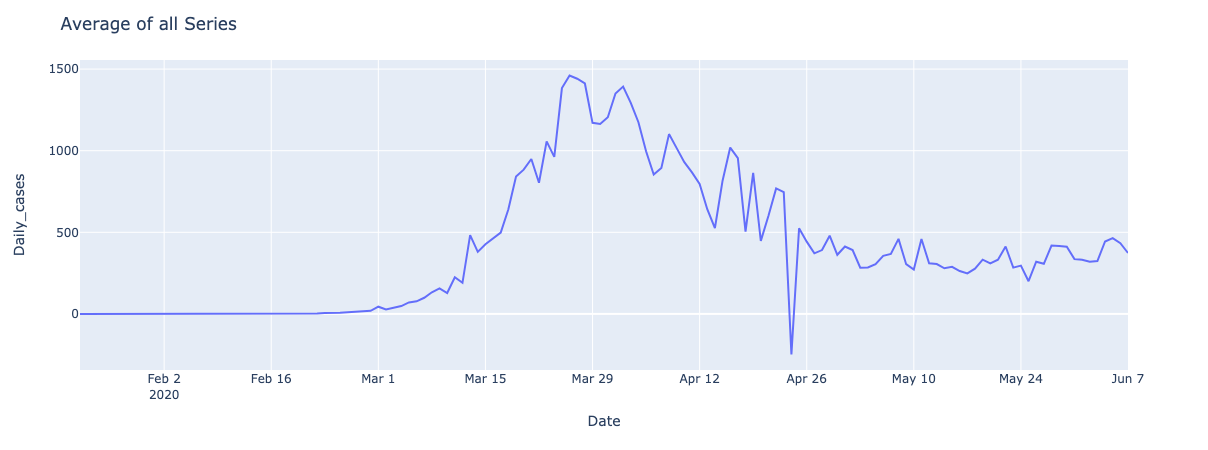

In [25]:
# Plot our average target over time
plot_series_average(training, ts_settings)
# """
# Plot average series 

# df: Pandas DataFrame
#     input data
# settings: timeseries settings (ts_settings)

# """

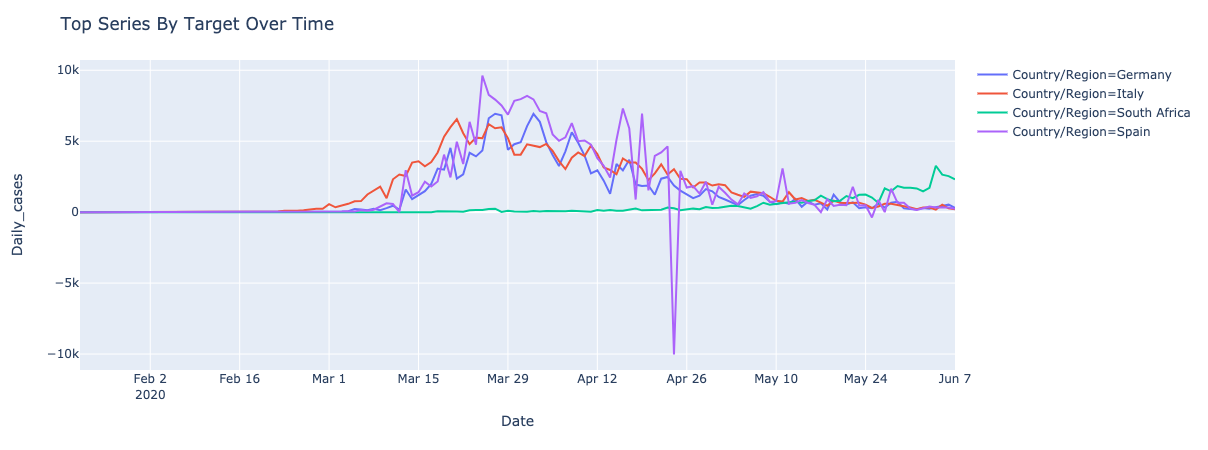

In [26]:
# Top 4 series
plot_individual_series(training, ts_settings, n=4, top=True)
# """
# Plot individual series on the same chart

# n: (int) number of series to plot
# top: (boolean) whether to select the top n largest or smallest series ranked by average target value
# """

-------------
# Clustering series

## To improve performance, it might make sense to cluster the series. The follow sections show use of functions that do this automatically

#### The 'add_cluster_labels' function will automatically test different numbers of clusters and can test different clustering strategies.


## Cluster strategies:
- Magnitude of series (size of target)
- Correlation of series
- Velocity of series (frequency of target)
- Zero-inflated series (lots of true zero-days?)
- build a 'generic' series for any new clusters

### The first clustering method 'correlation' relies upon the pearson correlation coefficient to see how strongly correlated individual sales series are, and assigns clusters based on highest correlation between series.

Testing 2 to 14 clusters
For n_clusters = 2, silhouette score is 0.6224192981136045
For n_clusters = 3, silhouette score is 0.5637253682014484
For n_clusters = 4, silhouette score is 0.4571373339826344
For n_clusters = 5, silhouette score is 0.41786634951476487
For n_clusters = 6, silhouette score is 0.4518502127193818
For n_clusters = 7, silhouette score is 0.41913160935343613
For n_clusters = 8, silhouette score is 0.41013523708115474
For n_clusters = 9, silhouette score is 0.38442944588179734
For n_clusters = 10, silhouette score is 0.1926626467036499
For n_clusters = 11, silhouette score is 0.17244112045576013
For n_clusters = 12, silhouette score is 0.12338950786213082
For n_clusters = 13, silhouette score is 0.10172957683134681
For n_clusters = 14, silhouette score is 0.07706769719936274
optimal n_clusters = 2, max silhouette score is 0.6224192981136045


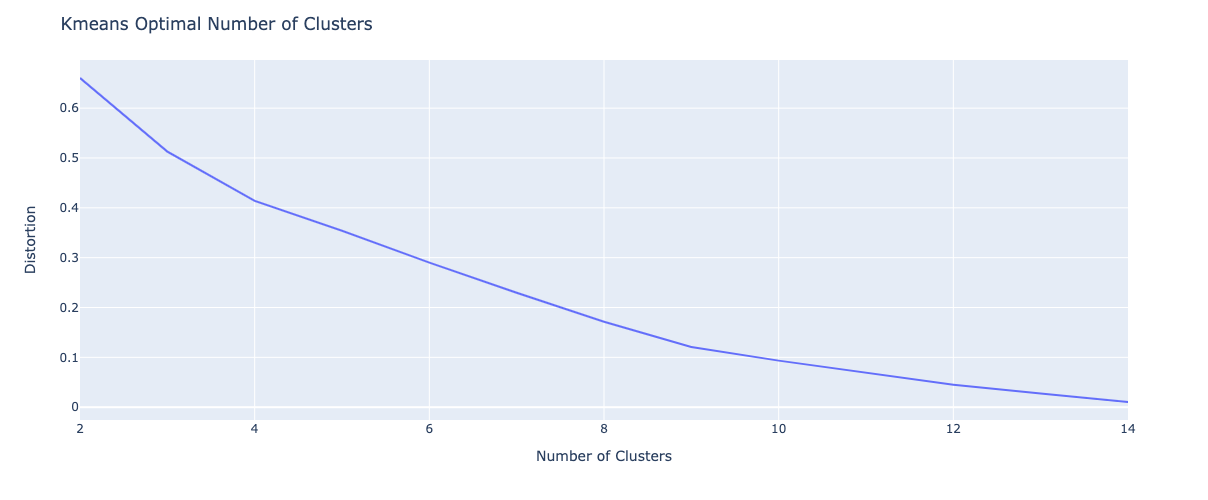

In [27]:
# Series clustering using 'correlation'
method='correlation'
nlags=None
alpha=None
scale=True
scale_method=None
split_method=None
n_clusters=None # providing a value for n_clusters will force that number of clusters to be used
max_clusters=14 # this needs to be < # series
plot=True

covid_clusters =  add_cluster_labels(training, 
                                    ts_settings, 
                                    method=method,
                                    scale=scale,
                                    scale_method=scale_method,
                                    alpha=alpha,
                                    nlags=nlags, 
                                    split_method=split_method,
                                    n_clusters=n_clusters, 
                                    max_clusters=max_clusters, 
                                    plot=plot)

### you can visualize the clusters in two ways:
- Target over time for each cluster
- Dimensionality reduction with coloring for each cluster

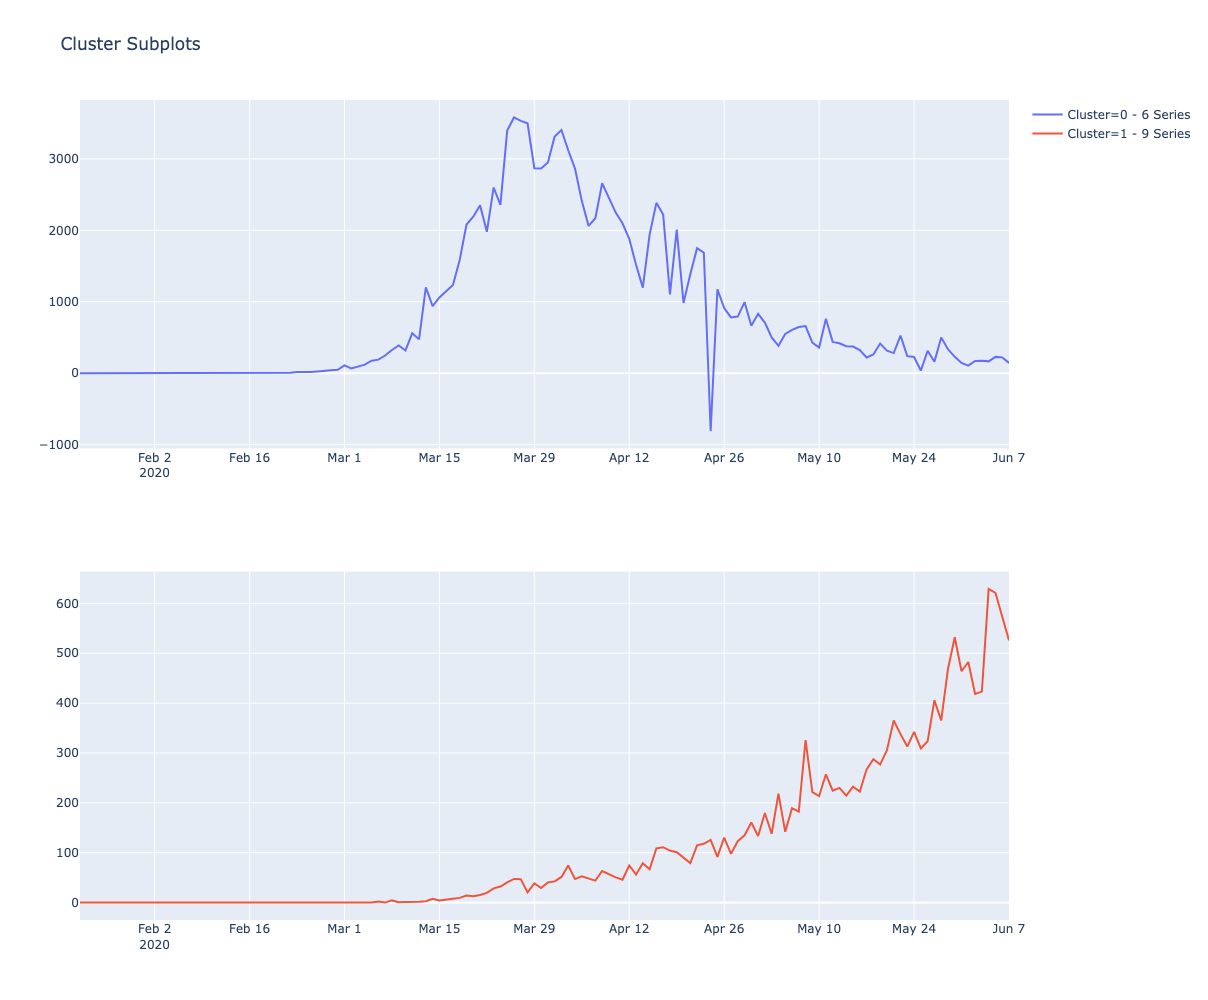

In [28]:
plot_clusters(covid_clusters, ts_settings)

In [29]:
# reshape the dataframe for dimensionality reduction
clusters_t_scaled = reshape_df(covid_clusters, ts_settings, scale= True)

# perform dimensionality reduction and plot the clustered data with labels
plot_UMAP(clusters_t_scaled, covid_clusters, ts_settings)

### Partial Autocorrelation Function (pacf) uses lagged values of the target to determine clusters. 'nlags' controls the number of lagged values generated, and the evaluation of the partial autocorrelation of a series allows for determination of similar time series. This is especially good for data with very strong periodic trends (ex. rotational data from engines, etc)

Testing 2 to 10 clusters
For n_clusters = 2, silhouette score is 0.3280099573665176
For n_clusters = 3, silhouette score is 0.3436891592918215
For n_clusters = 4, silhouette score is 0.31290149775515097
For n_clusters = 5, silhouette score is 0.2499927753359175
For n_clusters = 6, silhouette score is 0.2060114401713956
For n_clusters = 7, silhouette score is 0.1795987020492162
For n_clusters = 8, silhouette score is 0.1994321538729674
For n_clusters = 9, silhouette score is 0.2266923944474729
For n_clusters = 10, silhouette score is 0.21859036004597948
optimal n_clusters = 3, max silhouette score is 0.3436891592918215


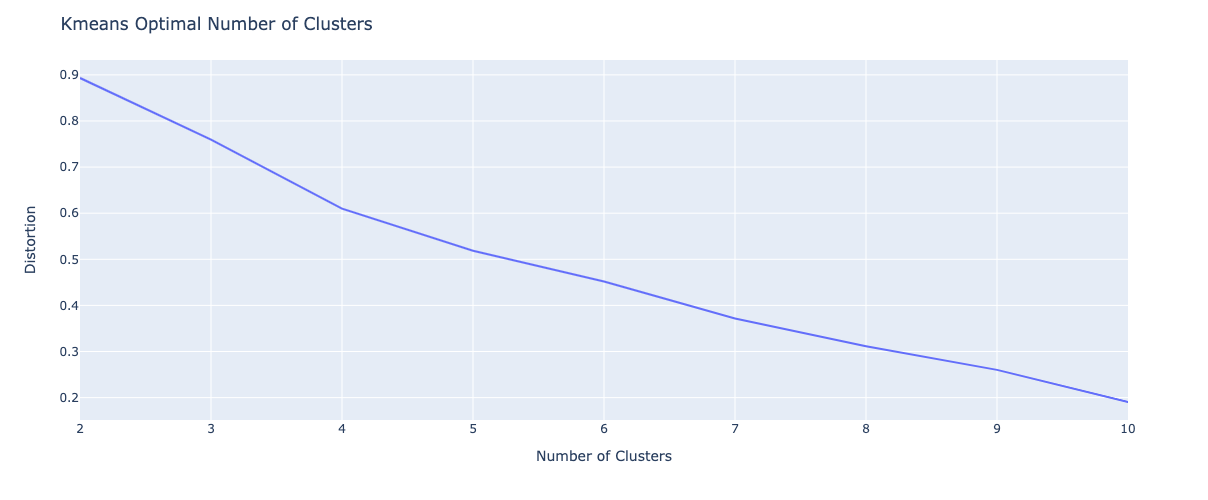

In [30]:
method='pacf'
nlags=7 # pacf method using AR(n) lags. nlags allowed values depend on dataset
alpha=0.025 #Set to None if you want keep raw coefficeints
scale=True
scale_method='normalize' # normalize or min_max
split_method= None # 'rank' or 'quantitles' allowed for 'target' method
n_clusters=None # define explicitly, or allow selection based onb max silhouette score
max_clusters=10 # int or None (# series - 1)
plot=True

covid_clusters =  add_cluster_labels(training, 
                                       ts_settings, 
                                       method=method,
                                       scale=scale,
                                       scale_method=scale_method,
                                       alpha=alpha,
                                       nlags=nlags, 
                                       n_clusters=n_clusters, 
                                       max_clusters=max_clusters, 
                                       plot=plot)


### 'Target' clustering will perform basic analysis of the target variable for a series and either be split by the rank, quantiles or if neither of those split_methods is provided will simply analyze the mean of each series. 

In [31]:
# target 
method='target'
nlags=None
alpha=None 
scale=True
scale_method='normalize'
n_clusters=None
split_method= 'rank' # rank or quantiles
max_clusters=5
plot=True

covid_clusters =  add_cluster_labels(training, 
                                       ts_settings, 
                                       method=method,
                                       scale=scale,
                                       scale_method=scale_method,
                                       alpha=alpha,
                                       nlags=nlags, 
                                       n_clusters=n_clusters, 
                                       split_method = split_method,
                                       max_clusters=max_clusters, 
                                       plot=plot)

------------
# Cluster the series using pACF and a lag of 7

### 3 clusters seems to give results that make sense

In [32]:
method='pacf'
nlags=7 # pacf method using AR(n) lags. nlags allowed values depend on dataset
alpha=0.025 #Set to None if you want keep raw coefficeints
scale=True
scale_method='normalize' # normalize or min_max
split_method= None # 'rank' or 'quantitles' allowed for 'target' method
n_clusters=3 # define explicitly, or allow selection based onb max silhouette score
max_clusters=10 # int or None (# series - 1)
plot=True

clusters =  add_cluster_labels(training, 
                                ts_settings, 
                                method=method,
                                scale=scale,
                                scale_method=scale_method,
                                alpha=alpha,
                                nlags=nlags, 
                                n_clusters=n_clusters, 
                                max_clusters=max_clusters, 
                                plot=plot)

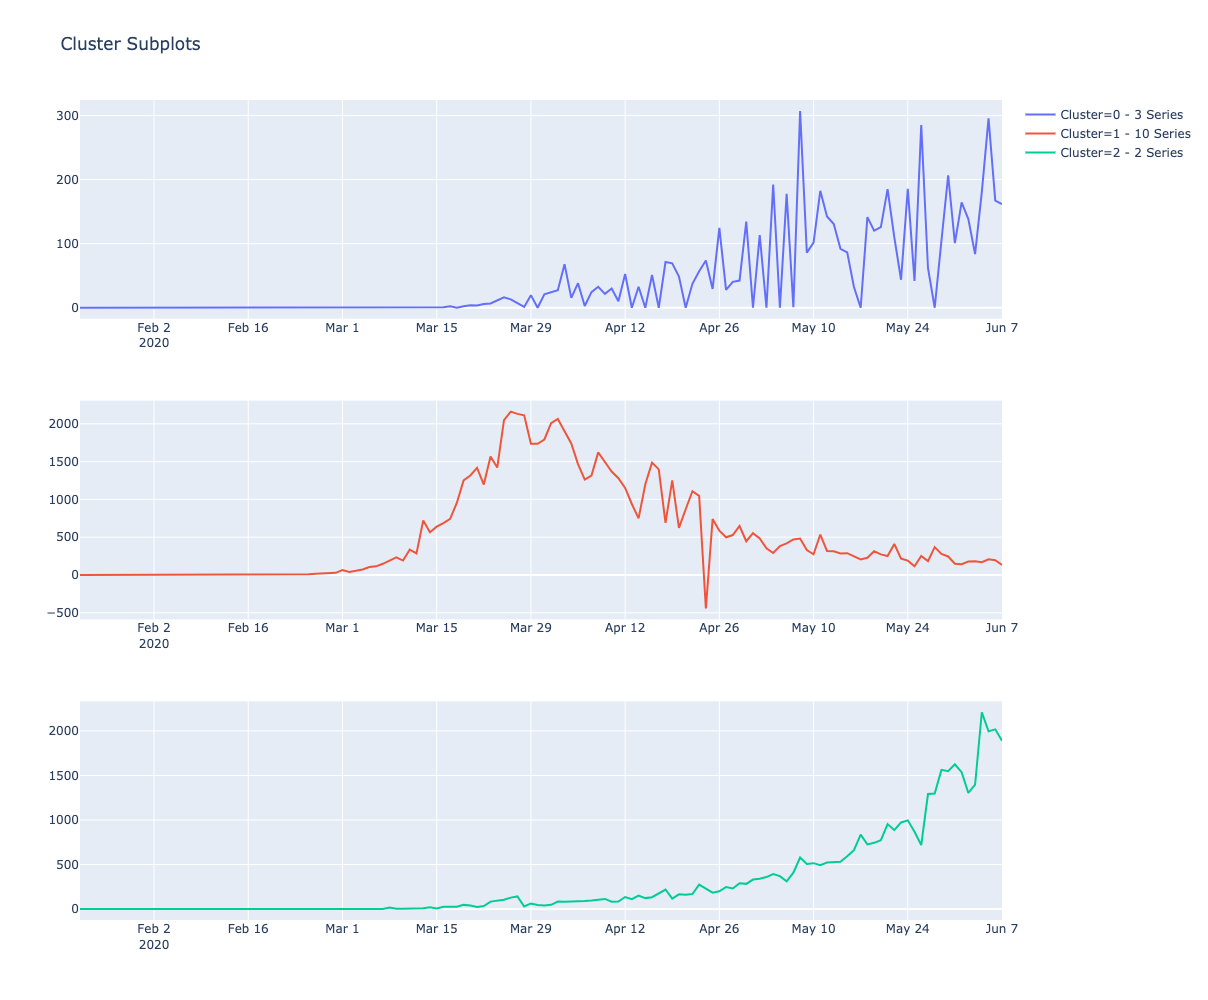

In [33]:
plot_clusters(clusters, ts_settings)

In [34]:
# reshape the dataframe for dimensionality reduction
clusters_t_scaled = reshape_df(clusters, ts_settings, scale= True)

# perform dimensionality reduction and plot the clustered data with labels
plot_UMAP(clusters_t_scaled, clusters, ts_settings)

--------------
# Cross Series Features

### In this dataset, it may be relevant to add cross series features from the other series in the same clusters

#### - The following function will create custom aggregations across groups
#### - group input is the precise label to be used with a pandas groupby function: df.groupby(group_input)
#### - group accepts multiple column names as inputs if provided in a list
#### - functions must be compatible with pandas df.transform(function) structure, which allows for user-defined functions

### at this point, you want to add the cluster-labels to the full dataset that you will use for building projects

In [36]:
# original df
print(covid.shape)

# training df for clustering
print(covid_clusters.shape)

# merge cluster labels
clusters = covid.merge(covid_clusters[['Country/Region','Cluster']], on= 'Country/Region', how= 'left').drop_duplicates()

# check output shape
print(clusters.shape)

(2505, 49)
(2070, 50)
(2505, 50)


In [37]:
# create cross series features automatically
covid_w_clusters = create_cross_series_features(clusters, 
                                             group=['Date','Cluster'], 
                                             cols=[target], 
                                             funcs=['mean','median','std','min','max'])
covid_w_clusters.head(2)

Country/Region  Cumulative_cases  Cumulative_deaths  Daily_cases  \
0        Algeria               0.0                0.0          0.0   
1        Algeria               0.0                0.0          0.0   

   Daily_deaths       DataLevel       Date  Time_since_1_Daily_cases_cases  \
0           0.0  Country/Region 2020-01-22                             0.0   
1           0.0  Country/Region 2020-01-23                             0.0   

   Time_since_30_Daily_cases_cases  Time_since_1_Daily_deaths_cases  \
0                              0.0                              0.0   
1                              0.0                              0.0   

   Time_since_30_Daily_deaths_cases  Time_since_1_Cumulative_cases_cases  \
0                                 0                                  0.0   
1                                 0                                  0.0   

   Time_since_30_Cumulative_cases_cases  Time_since_1_Cumulative_deaths_cases  \
0                                   0.0                                   0.0   
1                                   0.0                                   0.0   

   Time_since_30_Cumulative_deaths_cases  Confirmed_cases_change  \
0                                      0                    -1.0   
1                                      0                     0.0   

   Cumulative_cases_change  Confirmed_deaths_change  Cumulative_deaths_change  \
0                     -1.0                     -1.0                      -1.0   
1                      0.0                      0.0                       0.0   

   retail_and_recreation_percent_change_from_baseline  \
0                                                NaN    
1                                                NaN    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                                NaN   
1                                                NaN   

   parks_percent_change_from_baseline  \
0                                 NaN   
1                                 NaN   

   transit_stations_percent_change_from_baseline  \
0                                            NaN   
1                                            NaN   

   workplaces_percent_change_from_baseline  \
0                                      NaN   
1                                      NaN   

   residential_percent_change_from_baseline  Latest_Population_total  \
0                                       NaN               42228429.0   
1                                       NaN               42228429.0   

   5_year_percent_change_Population_total  Latest_GDP (current US$)  \
0                               10.719147              1.737580e+11   
1                               10.719147              1.737580e+11   

   5_year_percent_change_GDP (current US$)  Latest_GDP growth (annual %)  \
0                               -17.161379                           1.4   
1                               -17.161379                           1.4   

   5_year_percent_change_GDP growth (annual %)  \
0                                        -50.0   
1                                        -50.0   

   Latest_Population_male (% of total population)  \
0                                       50.515732   
1                                       50.515732   

   5_year_percent_change_Population_male (% of total population)  \
0                                            0.05532               
1                                            0.05532               

   Latest_Population ages 65 and above_total  \
0                                  2686782.0   
1                                  2686782.0   

   5_year_percent_change_Population ages 65 and above_total  \
0                                          24.974859          
1                                          24.974859          

   Latest_School enrollment_primary (% gross)  \
0                                   109.88282   
1                                   109.88282   



In [38]:
covid_w_clusters.to_csv('data/JHU_select_15_clustered.csv', index= None)

----------
# Build DR projects

#### These functions rely heavily on the ts_settings dictionary and the prefix used for the project. Generally you will want to use a uniquq prefix for the projects that will make it easy to retrieve just the results you want (in case you need to pull projects from a list of all your DR projects)

#### First, the Forecast Distance (FD) and Feature Derivation Windows (FDW) need to be defined. 

In [ ]:
# for NO clustering:
# use PACF clustering with 3 clusters
# build separate projects by FD, FDW, and/or cluster
fdws = [(-7,0), (-15,0), (-28,0), (-35,0)] # typically multiples of a seasonality are a good starting point
fds = [(1,15), (16,30)] # in this case, predicting one month is the goal

projects = create_dr_projects(covid_w_clusters, 
                             ts_settings, 
                             prefix='AFRICOM_daily_cases_1', # provide a prefix that will make it easy to search for only these projects
                             split_col= None, 
                             fdws=fdws, 
                             fds=fds, 
                             mode= dr.AUTOPILOT_MODE.QUICK) # FULL_AUTO, MANUAL, or QUICK

In [291]:
# if you want to get this list of projects later, if the variable has been overwritten, 
# if you are doing the modeling/analysis separately, etc...
tag = 'AFRICOM_daily_cases_1_'

# get only projects with that prefix that completed
# you can get errors if you attempt to run subsequent functions on a list of projects that has uncompleted projects with no models
projects = [x for x in dr.Project.list() if tag in str(x) and x.stage == 'modeling']

In [568]:
# use PACF clustering with 3 clusters
# build separate projects by FD, FDW, and/or cluster
fdws = [(-7,0), (-15,0), (-28,0), (-35,0)] # typically multiples of a seasonality are a good starting point
fds = [(1,15), (16,30)] # in this case, predicting one month is the goal

projects = create_dr_projects(covid_w_clusters, 
                             ts_settings, 
                             prefix='AFRICOM_cases_clustered_1', # provide a prefix that will make it easy to search for only these projects
                             split_col= 'Cluster', 
                             fdws=fdws, 
                             fds=fds, 
                             mode= dr.AUTOPILOT_MODE.QUICK) # FULL_AUTO, MANUAL, or QUICK

projects = [x for x in projects if x.stage == 'modeling']

Kicking off 24 projects

Building Next Project 
...

Creating project AFRICOM_cases_clustered_1_FD:1-15_FDW:-7_Cluster-0 ...
Project AFRICOM_cases_clustered_1_FD:1-15_FDW:-7_Cluster-0 was successfully built!

Building Next Project 
...

Creating project AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-0 ...
Project AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-0 was successfully built!

Building Next Project 
...

Creating project AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Cluster-0 ...
Project AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Cluster-0 was successfully built!

Building Next Project 
...

Creating project AFRICOM_cases_clustered_1_FD:16-30_FDW:-15_Cluster-0 ...
Project AFRICOM_cases_clustered_1_FD:16-30_FDW:-15_Cluster-0 was successfully built!

Building Next Project 
...

Creating project AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Cluster-0 ...
Project AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Cluster-0 was successfully built!

Building Next Project 
...

Creating project 

### You'll notice in the printed outputs of the above function that it will provide you a list of any projects that failed. You may want to re-run those projects specifically, or exclude them if you want to proceede with analysis

### It is very easy to iterate over different FDW and FD and you'll be able to easily see what worked well

In [569]:
# use PACF clustering with 3 clusters
# build separate projects by FD, FDW, and/or cluster
fds2 = [(1,10),(11,20),(21,30)] # in this case, predicting one month of sales is the goal

projects2 = create_dr_projects(covid_w_clusters, 
                             ts_settings, 
                             prefix='AFRICOM_cases_clustered_2', # provide a prefix that will make it easy to search for only these projects
                             split_col= 'Cluster', 
                             fdws=fdws, 
                             fds=fds2, 
                             mode= dr.AUTOPILOT_MODE.QUICK) # FULL_AUTO, MANUAL, or QUICK

projects2 = [x for x in projects2 if x.stage == 'modeling']

Kicking off 36 projects

Building Next Project 
...

Creating project AFRICOM_cases_clustered_2_FD:1-10_FDW:-7_Cluster-0 ...
Project AFRICOM_cases_clustered_2_FD:1-10_FDW:-7_Cluster-0 was successfully built!

Building Next Project 
...

Creating project AFRICOM_cases_clustered_2_FD:11-20_FDW:-7_Cluster-0 ...
Project AFRICOM_cases_clustered_2_FD:11-20_FDW:-7_Cluster-0 was successfully built!

Building Next Project 
...

Creating project AFRICOM_cases_clustered_2_FD:21-30_FDW:-7_Cluster-0 ...
Project AFRICOM_cases_clustered_2_FD:21-30_FDW:-7_Cluster-0 was successfully built!

Building Next Project 
...

Creating project AFRICOM_cases_clustered_2_FD:1-10_FDW:-15_Cluster-0 ...
Project AFRICOM_cases_clustered_2_FD:1-10_FDW:-15_Cluster-0 was successfully built!

Building Next Project 
...

Creating project AFRICOM_cases_clustered_2_FD:11-20_FDW:-15_Cluster-0 ...
Project AFRICOM_cases_clustered_2_FD:11-20_FDW:-15_Cluster-0 was successfully built!

Building Next Project 
...

Creating project 

## If you previously created these projects and need to get them again (because you reset the kernel, etc), it is simple:

In [45]:
tag1 = 'AFRICOM_cases_clustered_1'
tag2 = 'AFRICOM_cases_clustered_2'

projects = [x for x in dr.Project.list() if tag1 in str(x) and x.stage == 'modeling']
projects2 = [x for x in dr.Project.list() if tag2 in str(x) and x.stage == 'modeling']

--------
# Evaluate DR Projects

### The following section shows many functions for evaluating and comparing the performance of many DR projects

### The common inputs are the list of DR projects, the ts_settings, and outputs from previous functions

In [46]:
%%time
# you need to compute backtests before you can evaluate performance
compute_backtests(projects, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')
compute_backtests(projects2, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')

All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2
All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:1-15_FDW:-35_Cluster-2
All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:16-30_FDW:-28_Cluster-2
All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Cluster-2
All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:16-30_FDW:-15_Cluster-2
All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Cluster-2
All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-2
All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:1-15_FDW:-7_Cluster-2
All available backtests have been subm

In [47]:
%%time
# Get the results from completed projects
projects_scores = get_or_request_backtest_scores(projects, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=True, 
                                               metric='RMSE')

projects2_scores = get_or_request_backtest_scores(projects2, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=True, 
                                               metric='RMSE')


Scores for all 24 projects have been computed
Scores for all 36 projects have been computed
CPU times: user 3.89 s, sys: 362 ms, total: 4.25 s
Wall time: 2min 12s


In [48]:
projects_scores.head()

Project_Name  \
0  AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Clu...   
1  AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Clu...   
2  AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Clu...   
3  AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Clu...   
4  AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Clu...   

                 Project_ID                  Model_ID  \
0  5f11c877ab9af300d818cf6b  5f11c960aff54870235bf03b   
1  5f11c877ab9af300d818cf6b  5f11cb3d0320f7128a111ee4   
2  5f11c877ab9af300d818cf6b  5f11c962aff54870235bf046   
3  5f11c877ab9af300d818cf6b  5f11c961aff54870235bf03e   
4  5f11c877ab9af300d818cf6b  5f11ca7a083a30100883dee7   

                                          Model_Type  \
0       Baseline Predictions Using Most Recent Value   
1                                        AVG Blender   
2  eXtreme Gradient Boosted Trees Regressor with ...   
3  Performance Clustered eXtreme Gradient Boosted...   
4  eXtreme Gradient Boosted Trees Regressor with ...   

                  Featurelist  Backtest_1_RMSE  Backtest_1_MASE  \
0      Baseline Only (latest)        252.79986          1.00000   
1  With Differencing (latest)        274.41202          1.05544   
2  With Differencing (latest)        358.02058          1.35603   
3  With Differencing (latest)        401.45567          1.59017   
4     DR Reduced Features M19        411.71083          1.63094   

   Backtest_1_Theils_U  Backtest_1_SMAPE  Backtest_1_R_Squared  \
0              1.00000          61.32334               0.71376   
1              1.08549          43.20211               0.66272   
2              1.41622          50.06149               0.42589   
3              1.58804          97.12417               0.27813   
4              1.62860          56.29426               0.24078   

                  All_Backtests_RMSE           All_Backtests_MASE  \
0   [252.79986, 390.3065, 501.81481]              [1.0, 1.0, 1.0]   
1  [274.41202, 291.77508, 317.22835]  [1.05544, 0.78637, 0.60376]   
2   [358.02058, 328.1811, 379.95939]  [1.35603, 0.90512, 0.80243]   
3  [401.45567, 374.05734, 424.39344]  [1.59017, 0.98177, 0.90938]   
4  [411.71083, 371.88096, 309.26072]  [1.63094, 0.97579, 0.61012]   

        All_Backtests_Theils_U             All_Backtests_SMAPE  \
0              [1.0, 1.0, 1.0]   [61.32334, 59.1969, 72.09577]   
1  [1.08549, 0.74755, 0.63216]  [43.20211, 53.57145, 60.55785]   
2  [1.41622, 0.84083, 0.75717]  [50.06149, 62.36979, 89.40041]   
3  [1.58804, 0.95837, 0.84572]   [97.12417, 75.62781, 78.9621]   
4   [1.6286, 0.95279, 0.61628]  [56.29426, 63.45961, 63.91764]   

       All_Backtests_R_Squared Holdout_RMSE Holdout_MASE Holdout_Theils_U  \
0  [0.71376, 0.50816, 0.14737]         None         None             None   
1  [0.66272, 0.72514, 0.65927]         None         None             None   
2  [0.42589, 0.65227, 0.51118]         None         None             None   
3  [0.27813, 0.54826, 0.39017]         None         None             None   
4   [0.24078, 0.5535, 0.67617]         None         None             None   

  Holdout_SMAPE Holdout_R_Squared  
0          None              None  
1          None              None  
2          None              None  
3          None              None  
4          None              None

In [49]:
%%time
# get the peformance of all projects that have different FDSw/FDs
# the col_error corresponds to the output of get_or_request_backtest_scores()
# you need to define which column you want to use for analysis
scores_best = filter_best_fdw_scores(projects_scores, col_error='All_Backtests_RMSE')
scores2_best = filter_best_fdw_scores(projects2_scores, col_error='All_Backtests_RMSE')


CPU times: user 30.7 ms, sys: 3.02 ms, total: 33.7 ms
Wall time: 32.5 ms


In [50]:
scores_best.head()

Project_Name  \
88  AFRICOM_cases_clustered_1_FD:1-15_FDW:-35_Clus...   
80  AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Clu...   
55  AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Clus...   
70  AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Clus...   
25  AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Clus...   

                  Project_ID                  Model_ID  \
88  5f114c6b2bea52041326b52f  5f11551cdd1ffeccd386b36e   
80  5f1170c8ab9af3005618cdf8  5f118ecd083a30743b83d6dd   
55  5f11ad96ab9af300d818ce7e  5f11afa30320f7445d111ab5   
70  5f11aac62af76e005258b001  5f11ad48083a30417383da78   
25  5f11c35fab9af300d818cf21  5f11c64c083a3005c183de35   

                                           Model_Type  \
88                   Per Series nonseasonal AUTOARIMA   
80  eXtreme Gradient Boosted Trees Regressor with ...   
55  Performance Clustered Elastic Net Regressor wi...   
70                                        AVG Blender   
25                                        AVG Blender   

                             Featurelist  Backtest_1_RMSE  Backtest_1_MASE  \
88                Baseline Only (latest)        144.86622          0.64904   
80               DR Reduced Features M15        146.30877          0.82597   
55               DR Reduced Features M13        362.14025          0.50940   
70  With Differencing (average baseline)        553.76303          0.44318   
25               DR Reduced Features M15        178.09460          0.72273   

    Backtest_1_Theils_U  Backtest_1_SMAPE  Backtest_1_R_Squared  \
88              0.53537         118.75258               0.34984   
80              0.74669         117.44060               0.33683   
55              0.40032          59.24787               0.97082   
70              0.33642          85.66618               0.93178   
25              0.75415          34.02541               0.85794   

                   All_Backtests_RMSE           All_Backtests_MASE  \
88  [144.86622, 295.21812, 170.07086]  [0.64904, 0.81879, 0.85002]   
80  [146.30877, 293.92155, 160.22628]  [0.82597, 0.90404, 0.80177]   
55  [362.14025, 285.23648, 231.24955]    [0.5094, 0.59679, 0.4959]   
70  [553.76303, 652.88065, 618.23567]  [0.44318, 0.61909, 0.73121]   
25    [178.0946, 240.4902, 112.97261]   [0.72273, 0.91211, 0.5972]   

         All_Backtests_Theils_U                All_Backtests_SMAPE  \
88  [0.53537, 0.83474, 0.82897]  [118.75258, 125.67008, 134.29002]   
80  [0.74669, 0.88658, 0.73553]   [117.4406, 124.27227, 129.42543]   
55   [0.40032, 0.51498, 0.4104]     [59.24787, 50.19568, 55.91333]   
70  [0.33642, 0.58217, 0.62803]     [85.66618, 82.34414, 86.47873]   
25   [0.75415, 0.94221, 0.5851]     [34.02541, 36.99324, 34.94511]   

        All_Backtests_R_Squared Holdout_RMSE Holdout_MASE Holdout_Theils_U  \
88  [0.34984, 0.12705, 0.23314]         None         None             None   
80   [0.33683, 0.1347, 0.31935]         None         None             None   
55  [0.97082, 0.95877, 0.95836]         None         None             None   
70  [0.93178, 0.78399, 0.70241]         None         None             None   
25  [0.85794, 0.81327, 0.95679]         None         None             None   

   Holdout_SMAPE Holdout_R_Squared  
88          None              None  
80          None              None  
55          None              None  
70          None              None  
25          None              None

In [51]:
%%time
# find the best FDW/FD for each set of projects
# the col_error corresponds to the output of get_or_request_backtest_scores()
# you need to define which column you want to use for analysis
projects_best = filter_best_fdw_projects(projects_scores, projects, col_error='All_Backtests_RMSE')
projects2_best = filter_best_fdw_projects(projects2_scores, projects2, col_error='All_Backtests_RMSE')

CPU times: user 35.7 ms, sys: 2.16 ms, total: 37.8 ms
Wall time: 36.8 ms


In [52]:
# which FDW works best for each FD and cluster?
projects_best

[Project(AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2),
 Project(AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Cluster-2),
 Project(AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Cluster-1),
 Project(AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-1),
 Project(AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-0),
 Project(AFRICOM_cases_clustered_1_FD:1-15_FDW:-35_Cluster-0)]

In [53]:
%%time
# you can easily see the performance across clusters and series
# this function takes a few minutes to execute since it is getting lots of predictions from DR
# different metrics can be used, but need to be set in the get_cluster_acc() function using both the 'metric' and 'acc_calc' params
cluster_acc = get_cluster_acc(covid_w_clusters, 
                                 projects_best, 
                                 ts_settings, 
                                 data_subset='allBacktests', 
                                 include_blenders=False, 
                                 metric='RMSE', 
                                 acc_calc=rmse)
plot_cluster_acc(cluster_acc, ts_settings, data_subset='allBacktests', acc_calc=rmse)

Getting cluster accuracy...


CPU times: user 2.96 s, sys: 78.7 ms, total: 3.03 s
Wall time: 32.4 s


In [54]:
%%time
# this function takes a few minutes to execute since it is getting lots of predictions from DR
series_acc = get_series_acc(covid_w_clusters, 
                               projects_best, 
                               ts_settings, 
                               data_subset='allBacktests', 
                               include_blenders=True, 
                               metric='RMSE', 
                               acc_calc=rmse)
plot_series_acc(series_acc, ts_settings, data_subset='allBacktests', acc_calc=rmse, n= 50)

Getting series accuracy...


CPU times: user 3.23 s, sys: 60.5 ms, total: 3.29 s
Wall time: 34.3 s


In [55]:
# if you want to change the metric, you need to change those settings in both the get_series_acc() and plot_series_acc() functions
# you can also select different validation periods. currently 'allBacktests' and 'holdout' are supported
series_acc_smape = get_series_acc(covid_w_clusters, 
                               projects_best, 
                               ts_settings, 
                               data_subset='allBacktests', 
                               include_blenders=True, 
                               metric='SMAPE', 
                               acc_calc=smape)
plot_series_acc(series_acc_smape, ts_settings, data_subset='allBacktests', acc_calc=smape, n= 50)

Getting series accuracy...


Getting series accuracy...


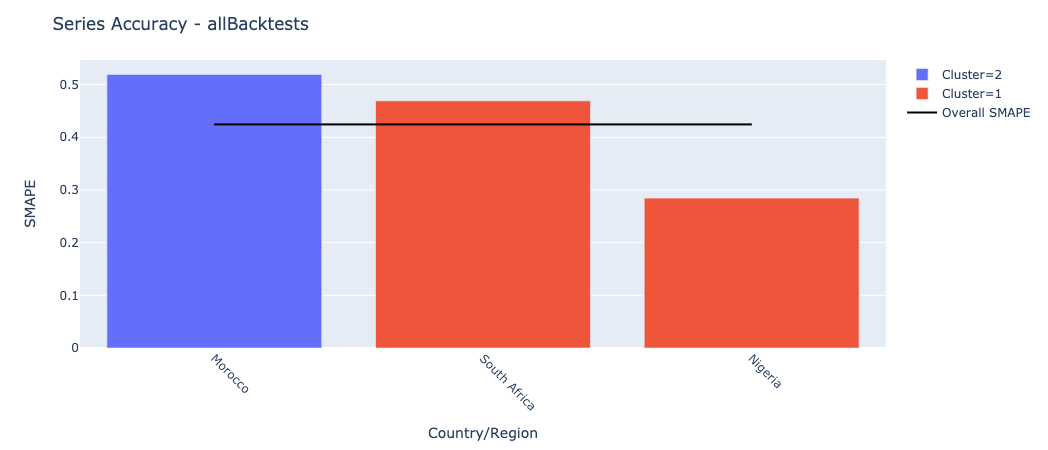

In [56]:
# if you want to analyze only a portion of the data, then just pass in a slice of that dataframe
africa_3_countries = ['Nigeria', 'Morocco', 'South Africa']
africa_3 = covid_w_clusters[covid_w_clusters['Country/Region'].isin(africa_3_countries)]
series_acc_smape = get_series_acc(africa_3, 
                               projects_best, 
                               ts_settings, 
                               data_subset='allBacktests', 
                               include_blenders=True, 
                               metric='SMAPE', 
                               acc_calc=smape)
plot_series_acc(series_acc_smape, ts_settings, data_subset='allBacktests', acc_calc=smape, n= 50)

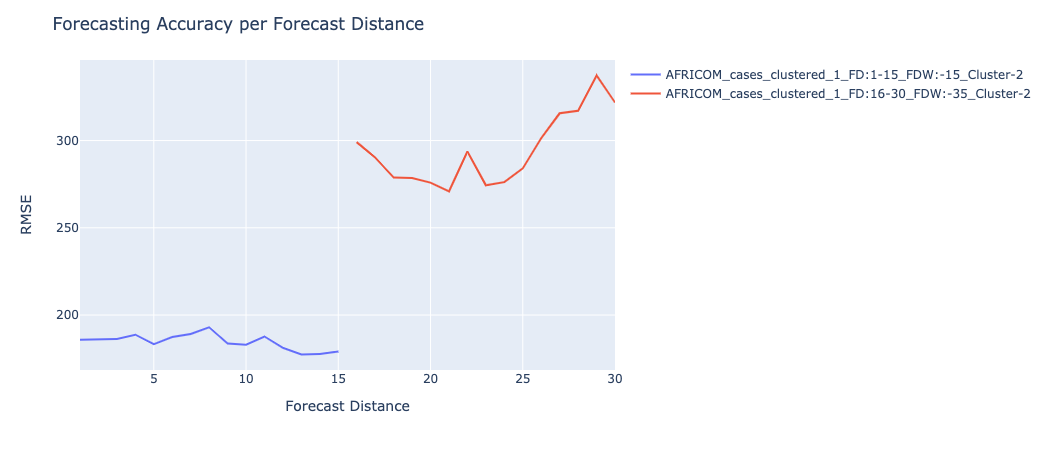

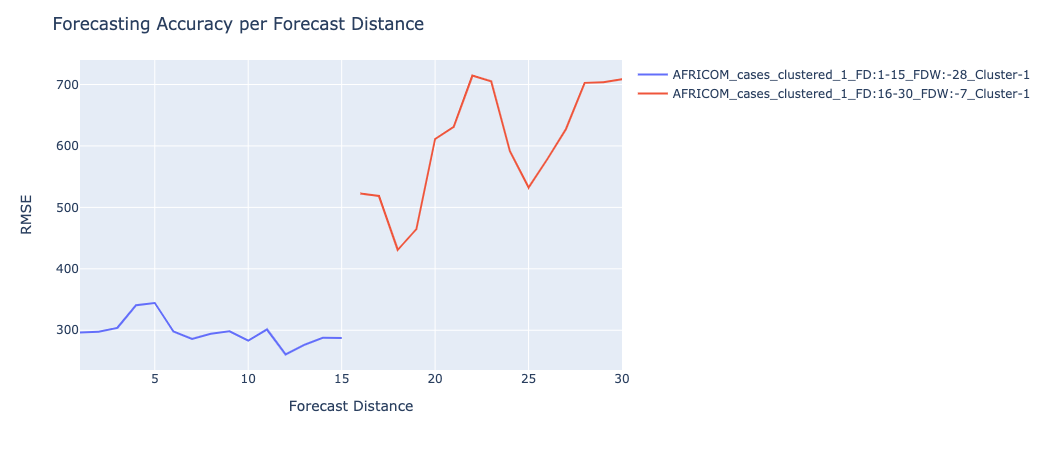

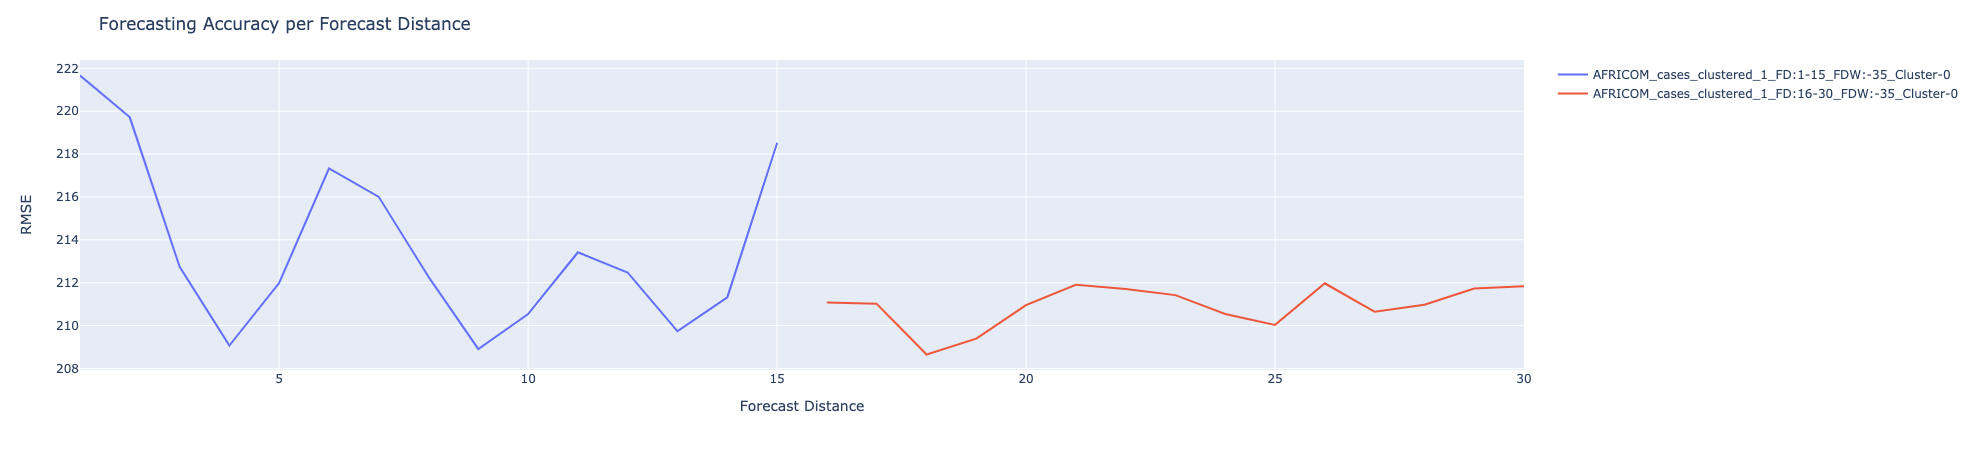

In [57]:
# Project 1
# using the outputs from the above functions, you can get the Accuracy by FD for all projects (even when multiple FDs are required)
# you can define the metric and data_subset to be used. 'allBacktests' and 'holdout' are allowed for data_subset
plot_fd_accuracy_by_cluster(covid_w_clusters, projects_scores, projects_best, ts_settings, data_subset='allBacktests', metric='RMSE')

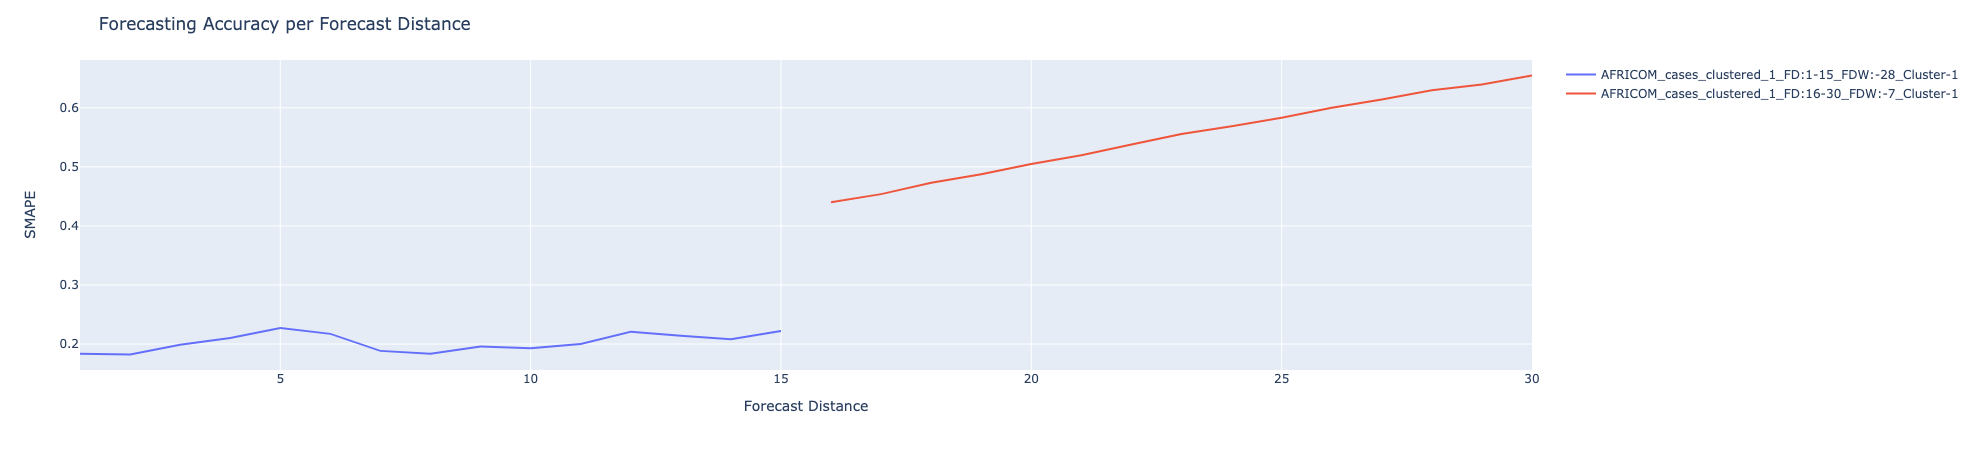

In [82]:
# Project 1
# as above, you can look at specific series by just passing in the df that contains only those series
# but if the series aren't present in all clusters, then you need to select only the projects that contain the series of interest
# Cluster-1 in this case
africa_3_projects_scores = projects_scores[projects_scores['Project_Name'].str.contains('Cluster-1')]
africa_3_projects_best = [x for x in projects_best if 'Cluster-1' in str(x)]
plot_fd_accuracy_by_cluster(africa_3, africa_3_projects_scores, africa_3_projects_best, ts_settings, data_subset='allBacktests', metric='SMAPE')

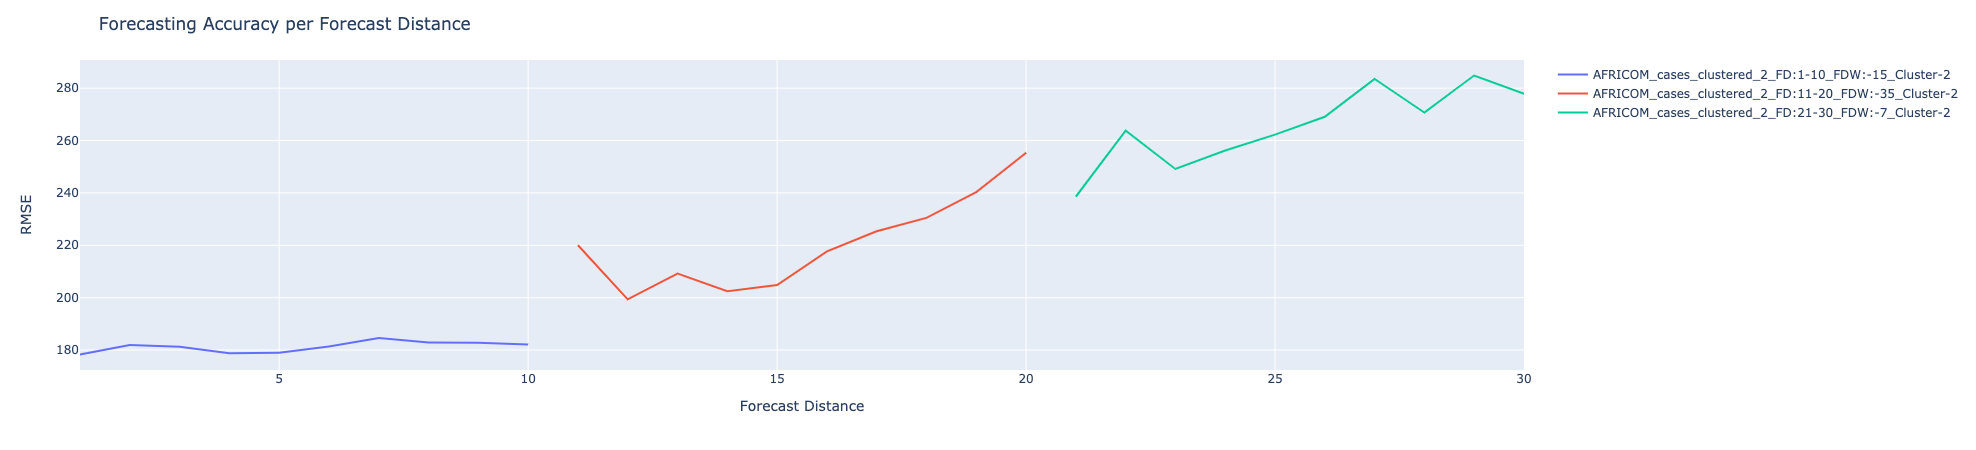

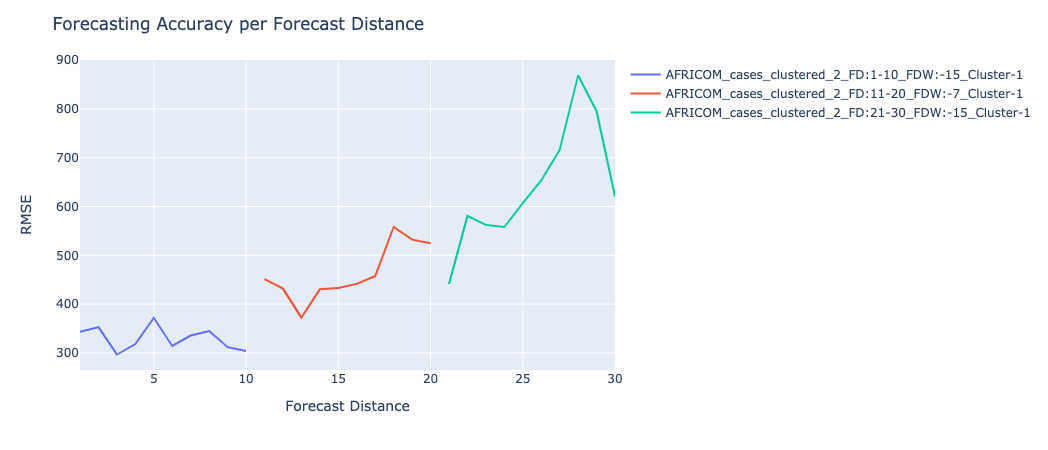

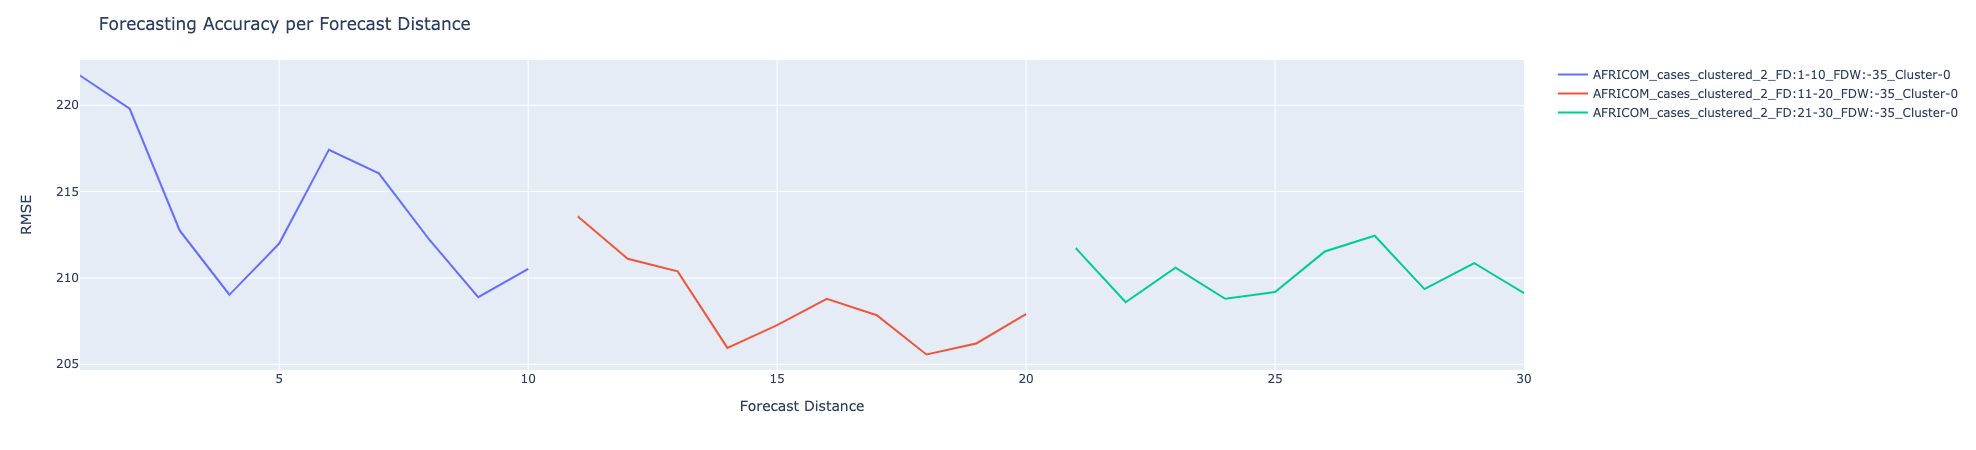

In [83]:
# Project 2
# here we see that more FDs are used
plot_fd_accuracy_by_cluster(covid_w_clusters, projects2_scores, projects2_best, ts_settings, data_subset='allBacktests', metric='RMSE')

-----------------
# Retrain models on reduced features

### To potentially improve performance, models can be retrained on a reduced feature set. Model ranking by Backtest or Holdout data is available, and requires no additional modification of the inputs.

## Different strategies
- single-pass retraining that selects features that combine to give some threshold of total feature impact
- multi-pass retraining where iteratively fewer features (based on threshold of total feature impact) are used to train models and evaluate performance

### Lets start by quickly retraining on a reduced feature set for all clusters and see if we get much performance lift across all models at a single threshold

In [84]:
%%time
# Create a new reduced features feature list per top model and retrain
train_reduced_features_models(projects_best, n_models=1, threshold=0.9, data_subset='allBacktests', include_blenders=False, metric='RMSE')

# you can add the compute and wait for functions if you want results immediately
wait_for_jobs_to_process(projects_best)
compute_backtests(projects, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')
wait_for_jobs_to_process(projects_best)

# you notice some errors in the output because this was already run for these projects

422 client error: {'message': 'Feature list named Top 12 features M19 already exists'}
Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 7 features M88
Training Performance Clustered Elastic Net Regressor with Forecast Distance Modeling on Featurelist Top 12 features M63
Training Performance Clustered Elastic Net Regressor with Forecast Distance Modeling on Featurelist Top 7 features M10
Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 7 features M66
422 client error: {'message': 'This blueprint requires Naive Prediction features to be present in feature list.'}
There are 1 jobs still processing
All jobs have finished processing...
Computing backtests for model 5f11fb38600fc306f4471939 in Project AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2
All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2
All available backtests have been submitt

### The other option is to do iterative feature reduction for a single project or for many projects

In [85]:
%%time
# run this for a single project
# note: these have already been run, so the output errors shown below are associated with these feature lists already having been computed
one_project = test_feature_selection(covid_w_clusters, projects_best[1:2], ts_settings, threshold_range= (0.4, 1.0), step_size = 0.2)

Training eXtreme Gradient Boosted Trees Regressor with Early Stopping on Featurelist Top 5 features M15
Applying this threshold would result in a featurelist with no features
Applying this threshold would result in a featurelist with no features
CPU times: user 546 ms, sys: 89.4 ms, total: 635 ms
Wall time: 22.8 s


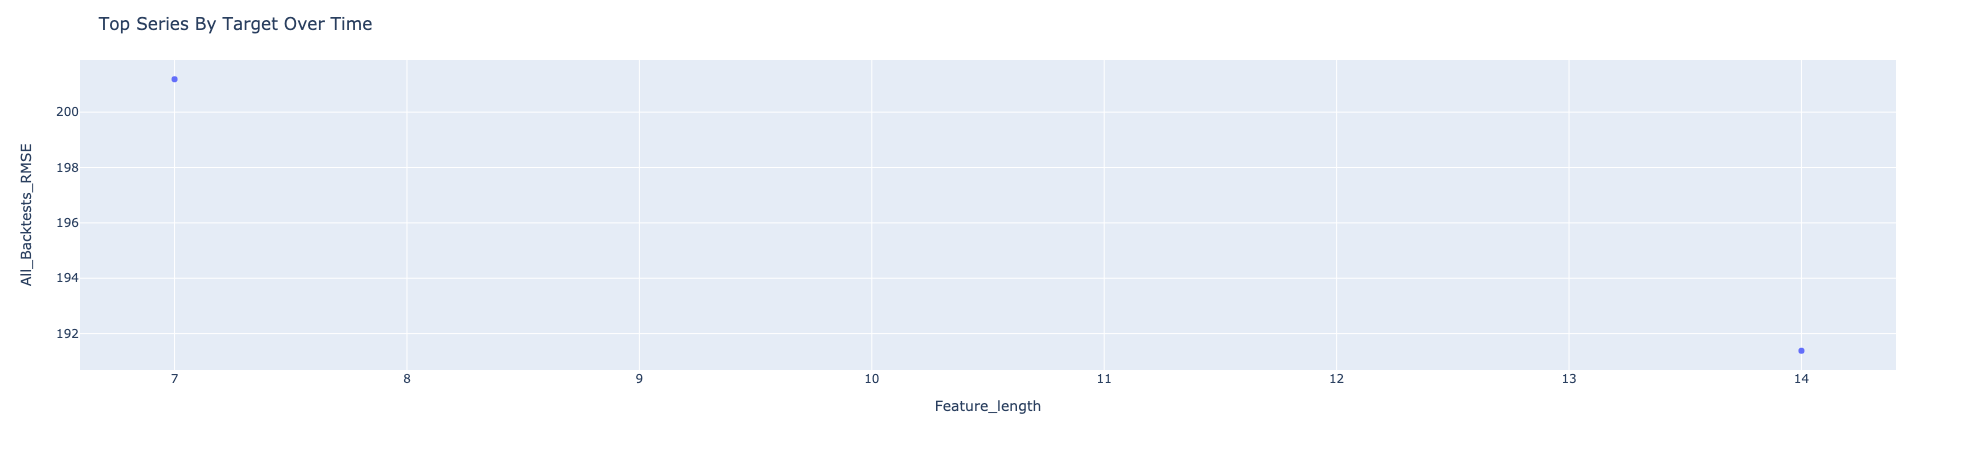

CPU times: user 266 ms, sys: 71.7 ms, total: 338 ms
Wall time: 348 ms


In [86]:
%%time
# plot the results
# not very interesting or helpful in this case
plot_featurelist_learning_curve(one_project, data_subset= 'allBacktests', metric= 'RMSE')

In [87]:
%%time
# perform this for all of the projects
# you see some errors here because I've already run this feature reduction
# I have not implemented the model-rank-specific changes that allow you to take n-ranked model specifically
# if it would be useful, reach out to Jarred Bultema and I can add it
projects1 = run_feature_selection_projects(covid_w_clusters, projects_best, ts_settings, threshold_range= (0.3, 0.9), step_size = 0.2, plot= False)
projects1.shape

Getting ranked models from 6 projects ...
Training reduced feature lists for 6 projects ...

Retraining the 2-ranked model ...
------------
422 client error: {'message': 'Feature list named Top 12 features M19 already exists'}
422 client error: {'message': 'Feature list named Top 1 features M19 already exists'}
Applying this threshold would result in a featurelist with no features
Applying this threshold would result in a featurelist with no features

Retraining the 2-ranked model ...
------------
422 client error: {'message': 'Feature list named Top 14 features M15 already exists'}
422 client error: {'message': 'Feature list named Top 1 features M15 already exists'}
Applying this threshold would result in a featurelist with no features
Applying this threshold would result in a featurelist with no features

Retraining the 1-ranked model ...
------------
422 client error: {'message': 'Feature list named Top 12 features M63 already exists'}
Training Performance Clustered Elastic Net Regr

(30, 20)

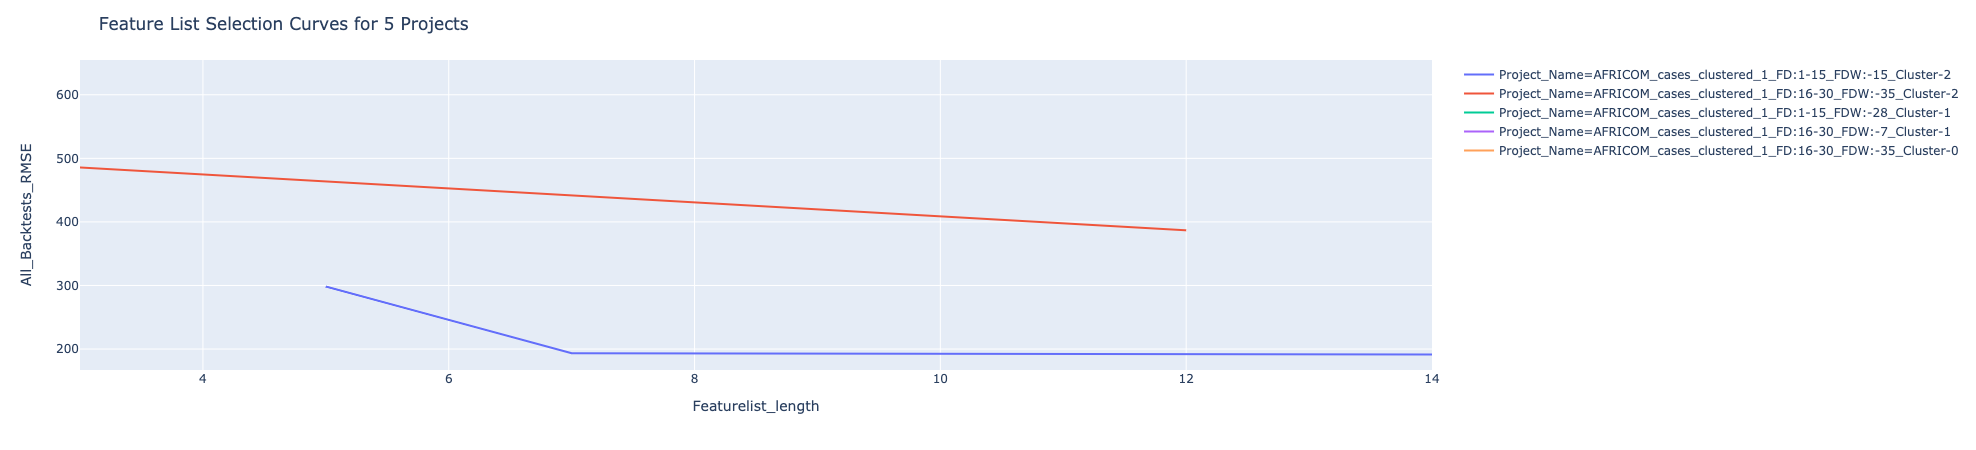

CPU times: user 288 ms, sys: 69.5 ms, total: 357 ms
Wall time: 385 ms


In [88]:
%%time
# sometimes you see strong effects from reducing features, here not so much
plot_all_featurelist_curves(projects1, ts_settings, data_subset= 'allBacktests', metric= 'RMSE')


## *** Note on retraining with reduced feature lists for some blueprints

#### - Not all blueprints will support retraining on reduced feature lists if required features are dropped from the feature lists. This occurs commonly when a required naive-baseline feature is dropped from a feature lists. Zero-inflated models and VAR models appears to results in these errors as well.

#### - By default, these functions will take the highest-ranked non-blender model on the leaderboard. Optionally, you can put the leaderboard rank (starting from 1) as a parameter (model_rank= n) and it will take the number 'n' ranked model for feature selection testing. Zero-inflated models generally cannot be used for this process, and there may be other, unknown blueprint-specific interactions or limitations.

In [89]:
# get a model based on leaderboard rank
get_ranked_model(project= projects_best[4], model_rank= 2, metric= 'RMSE', data_subset= 'allBacktests')

[DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping')]

In [90]:
# the test_feature_selection() function allows you to input model-rank to retrain the model of your choice

# test_feature_selection()

#     '''
#     df: pandas df
#     projects: list
#         list of DataRobot projects for feature list selection
#     ts_settings: dict
#         Parameters for time series project
#     n_models: int
#         number of models to generate feature lists from
#     data_subset: str
#         Choose from either holdout or allBacktests
#     metric: str
#         Metric to be used for sorting the leaderboard, if None uses project metric
#     threshold_range: tuple of np.floats (optional)
#         upper and lower bounds of threshold for feature selection, percentage of cumulate feature impact
#     step_size: np.float (optional)
#         step-size across threshold-range
#     model_rank: int (optional)
#         None if top model, model leaderboard rank if any model other than top desired
#     --------
#     Returns:
#     Pandas DataFrame
#     '''

In [91]:
%%time
# run this for a single project with a model-rank specified
# note: these have already been run, so the output errors shown below are associated with these feature lists already having been computed
one_project = test_feature_selection(covid_w_clusters, projects_best[0:1], ts_settings, threshold_range= (0.4, 1.0), step_size = 0.2, model_rank= 2)

422 client error: {'message': 'Feature list named Top 3 features M19 already exists'}
Applying this threshold would result in a featurelist with no features
Applying this threshold would result in a featurelist with no features
CPU times: user 501 ms, sys: 28.2 ms, total: 529 ms
Wall time: 21.2 s


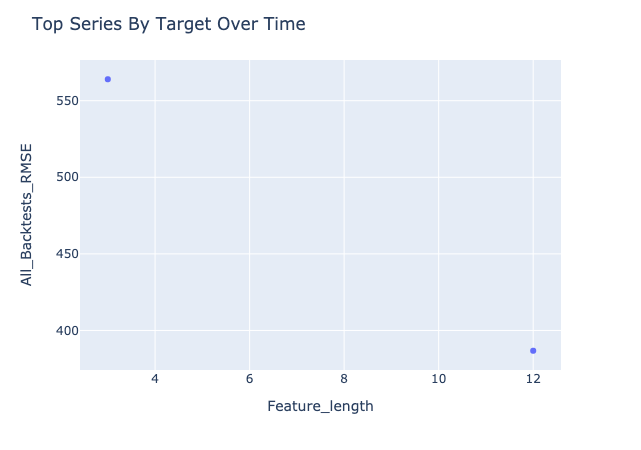

CPU times: user 430 ms, sys: 273 ms, total: 703 ms
Wall time: 857 ms


In [92]:
%%time
# plot the results
# not very interesting or helpful in this case
# you can see multiple points for 3-length featurelists, because of all of the above runs
plot_featurelist_learning_curve(one_project, data_subset= 'allBacktests', metric= 'RMSE')

----------
# Train Timeseries blenders



In [95]:
%%time
# You can also create time-series blenders for many projects
# either explicitly define models for each project within a list: list of lists where each-sublist contains the model-ids that correspond to the project with the same index in the project list
# or select how many of the top-models you want DataRobot to automatically blend
train_timeseries_blender_projects(projects_best, models= None, n_models= 5, blender_method= 'FORECAST_DISTANCE_ENET')


Creating Forecast Distance Enet blender using 4 models from AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2 ... 
Creating Forecast Distance Enet blender using 3 models from AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Cluster-2 ... 
Creating Forecast Distance Enet blender using 5 models from AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Cluster-1 ... 
Creating Forecast Distance Enet blender using 3 models from AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-1 ... 
Creating Forecast Distance Enet blender using 3 models from AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-0 ... 
Creating Forecast Distance Enet blender using 5 models from AFRICOM_cases_clustered_1_FD:1-15_FDW:-35_Cluster-0 ... 
CPU times: user 435 ms, sys: 38.9 ms, total: 474 ms
Wall time: 18.3 s


In [96]:
%%time
# You can also create time-series blenders for many projects
# either explicitly define models for each project within a list: list of lists where each-sublist contains the model-ids that correspond to the project with the same index in the project list
# or select how many of the top-models you want DataRobot to automatically blend
train_timeseries_blender_projects(projects_best, models= None, n_models= 5, blender_method= 'FORECAST_DISTANCE_AVG')


Creating Forecast Distance Avg blender using 4 models from AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2 ... 
Creating Forecast Distance Avg blender using 3 models from AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Cluster-2 ... 
Creating Forecast Distance Avg blender using 5 models from AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Cluster-1 ... 
Creating Forecast Distance Avg blender using 3 models from AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-1 ... 
Creating Forecast Distance Avg blender using 3 models from AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-0 ... 
Creating Forecast Distance Avg blender using 5 models from AFRICOM_cases_clustered_1_FD:1-15_FDW:-35_Cluster-0 ... 
CPU times: user 437 ms, sys: 14.3 ms, total: 452 ms
Wall time: 21.5 s


In [97]:
compute_backtests(projects_best, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')
projects1_scores = get_or_request_backtest_scores(projects_best, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=True, 
                                               metric='RMSE')
scores1_best = filter_best_fdw_scores(projects1_scores, col_error='All_Backtests_RMSE')
projects1_best = filter_best_fdw_projects(projects1_scores, projects, col_error='All_Backtests_RMSE')


All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2
All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Cluster-2
All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Cluster-1
Computing backtests for model 5f12068999c13706b7e22a25 in Project AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-1
Computing backtests for model 5f12068299c137061be239dc in Project AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-1
All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-1
Computing backtests for model 5f1206a0d7bc5b06e9a1187f in Project AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-0
All available backtests have been submitted for scoring for project AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-0
All available backtests have been submitted

--------
# Run the Repo...

### When all else fails and you've got time, then you can consider running many models from the repository. By default, this function will use the featurelist from the DataRobot recommended blueprint. If you want to be 'insane' (insane = True), you can run the repo on the featurelist from the top-5 blueprints on the leaderboard.

In [98]:
# use a sledgehammer...
# the code runs quite fast, and then you have to wait for all of the blueprints to train
# n_bps allows you to only take n-bps in alphabetical order
# set n_bps = None to run the whole repo for each feature list
run_repository_models(projects1_best, n_bps= 5, insane= False, exclude= ['Mean', 'Eureqa', 'Keras', 'VARMAX'])

Attemping training of 5 blueprints in AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2 ...
5 new blueprints were trained
0 blueprints were unable to train or had an error

Attemping training of 5 blueprints in AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Cluster-2 ...
5 new blueprints were trained
0 blueprints were unable to train or had an error

Attemping training of 5 blueprints in AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Cluster-1 ...
5 new blueprints were trained
0 blueprints were unable to train or had an error

Attemping training of 5 blueprints in AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-1 ...
5 new blueprints were trained
0 blueprints were unable to train or had an error

Attemping training of 5 blueprints in AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-0 ...
5 new blueprints were trained
0 blueprints were unable to train or had an error

Attemping training of 5 blueprints in AFRICOM_cases_clustered_1_FD:1-15_FDW:-35_Cluster-0 ...
0 new blueprints were trained

----------------
# Getting training predictions

### In the model evaluation and interation process, you may want the training predictions. These can easily be obtained via a function 'get_preds_and_actuals':

In [99]:
%%time
# get predictions for all series
# this function can take a while to run
test_predictions = get_preds_and_actuals(df= covid_w_clusters, projects= projects1_best, ts_settings= ts_settings, include_blenders= True, metric= 'RMSE')

CPU times: user 2.3 s, sys: 302 ms, total: 2.6 s
Wall time: 32.6 s


## It may also be relevant to plot the actuals and predictions.

####  The following 'plot_preds_and_actuals()' function can plot the average across all series, the top series, a named series, plotting individual forecast distances, and allows for control over the aggregation of predictions for a single date from forecast distance predictions

Getting series predictions from DataRobot...


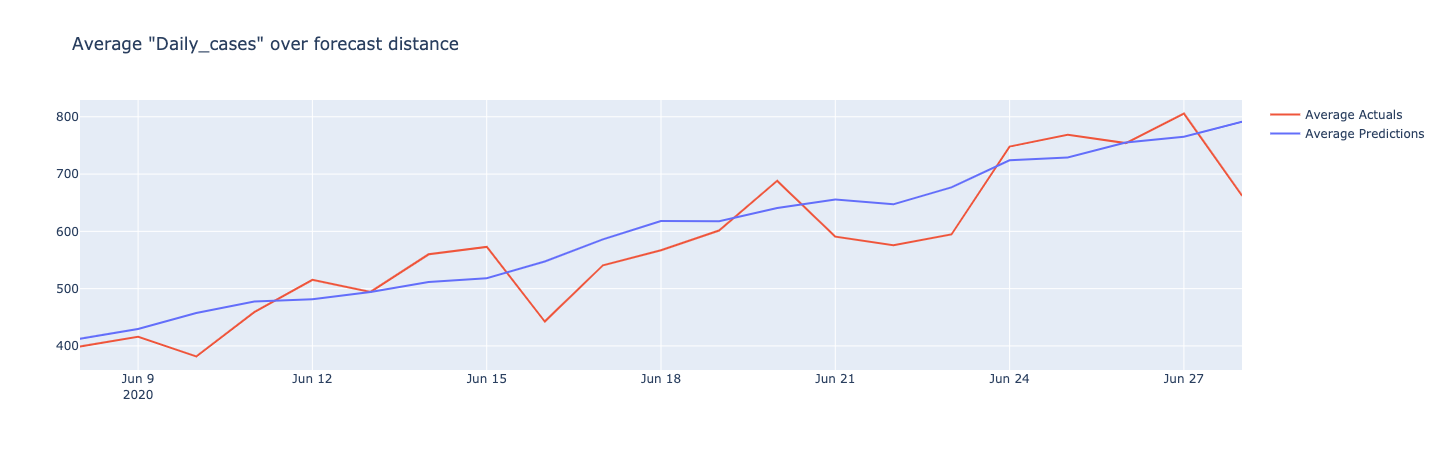

CPU times: user 2.72 s, sys: 72.3 ms, total: 2.79 s
Wall time: 34.3 s


In [100]:
%%time
# plot the average for all series
# this function also takes a while to run because it is directly pulling preds and actuals from DR
# eventually I need to create a version that uses the above predictions file
plot_preds_and_actuals(covid_w_clusters, projects_best, ts_settings, fd_range=None, fd_agg= 'mean', fd= None, average= True, series_name= None, top=True, data_subset= 'allBacktests', include_blenders=True, metric= None, acc_calc=rmse)

### There are lots of options for this plotting function.
#### Currently (almost) the only thing it doesn't do is plot out using FD counting up (i.e. FP+1 = FD1, FP+2 = FD2, etc)
#####  (There is code to do ^ from Justin S., but I haven't tested or implemented it yet.)

### plot_preds_and_actuals(
    df, 
    projects, 
    ts_settings, 
    fd_range=None, 
    fd_agg= 'mean', 
    fd= None, 
    average= True, 
    series_name= None, 
    top=None, 
    data_subset= 'allBacktests', 
    include_blenders=False, 
    metric= None, 
    acc_calc=rmse):

    """
    Get series-level and overall accuracy across multiple DataRobot projects

    df: pandas df
    projects: list
        DataRobot project object(s)
    ts_settings: dict
        Parameters for time series project
    fd_range: tuple of ints
        FD start and stop for plotting, None will select all FD
    fd_agg: str
        Aggregation of multiple predictions for a date, accepts 'min', 'max', 'mean'
    fd: int
        Specify FD to plot predictions vs actuals using only that FD
    average: bool
        If plotting average values or individual series
    series_name: str
        Series name (str) to plot
    top: bool
        Plot highest or lowest ordered series by mean target value
    data_subset: str
        Valid values are either holdout or allBacktests
    include_backtests: boolean (optional)
        Controls whether blender models are considered
    metric: str (optional)
        Project metric used to sort the DataRobot leaderboard
        Choose from list of 'MASE', 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
                            'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'
    acc_calc: function
        Function to calculate row-level prediction accuracy. Choose from mae, rmse, mape, smape, gamma, poission, and tweedie
        
    Returns:
    --------
    Plotly lineplot
    """

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


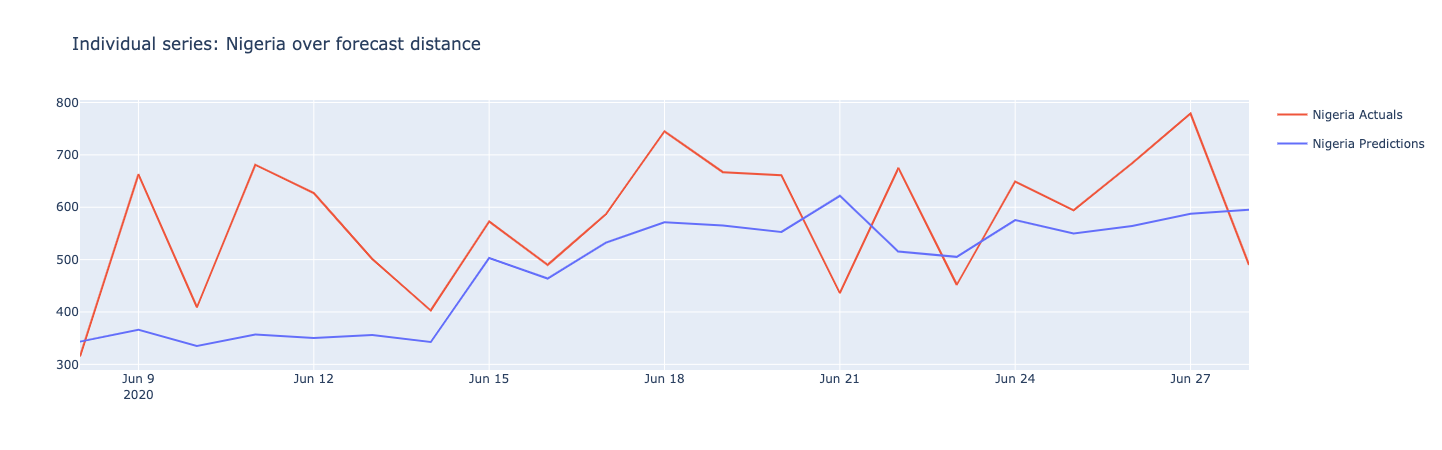

In [101]:
# plot a specific series by name: 'Nigeria'
# plot only the last 15 fds (fd_range= (16,30))
plot_preds_and_actuals(covid_w_clusters, projects1_best, ts_settings, fd_range= (16, 30), fd_agg= 'mean', fd= None, average= False, series_name= 'Nigeria', top=False, data_subset= 'allBacktests', include_blenders=True, metric= 'RMSE', acc_calc=rmse)

-----
# Retraining models to a defined forecast point

### The covid-project requires that we be able to retrain models up to a specified forecast point so we aren't using future training data to predict on a forecast point in the past. I've modified the ts_helper scripts to accomodate this functionality, but there are some odd behaviors and made be un-found bugs still.

#### Reach out to Jess Lin or Jarred Bultema if you find bugs

In [102]:
%%time
# you can specify a single project, models, and  duration
# by default, the training duration of the specified/top model will be used from the retraining point
# if you do not provide a DataRobot datetime model object to be retrained, then the top non-blender will be used

test_model = retrain_to_forecast_point(project= projects[0], ts_settings = ts_settings, forecast_point= '06-02-2020', model= None, duration= 45, metric= 'RMSE')

Retraing Frozen DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping') from 2020-04-18 to 2020-06-02... 
There are 2 jobs still processing
All jobs have finished processing...
Retraining Complete!
CPU times: user 175 ms, sys: 8.49 ms, total: 184 ms
Wall time: 1min 7s


In [103]:
test_model.training_info

{'holdout_training_start_date': datetime.datetime(2020, 4, 18, 0, 0, tzinfo=tzutc()),
 'holdout_training_duration': 'P45D',
 'holdout_training_row_count': 3375,
 'holdout_training_end_date': datetime.datetime(2020, 6, 2, 0, 0, tzinfo=tzutc()),
 'prediction_training_start_date': datetime.datetime(2020, 4, 18, 0, 0, tzinfo=tzutc()),
 'prediction_training_duration': 'P45D',
 'prediction_training_row_count': 3375,
 'prediction_training_end_date': datetime.datetime(2020, 6, 2, 0, 0, tzinfo=tzutc())}

### Getting predictions from the training data has some odd interactions because the new forecast points likely don't correspond well to a validation/holdout period.

### You can get some errors that correspond directly to a specific forecast point and aren't easily fixed, but there is another option

In [104]:
test_pred_fixed = get_preds_and_actuals_fixed_forecast_point(
    df= covid_w_clusters,
    projects= projects_best[0:1],
    ts_settings= ts_settings,
    forecast_point= '06-02-2020',
    models= [test_model],
    n_models=1,
    data_subset='allBacktests',
    include_blenders=True,
    metric=None
)

IndexError: list index out of range

### But using the same model for a different forecast point things work fine if there is enough alignment of the forecast point and a validation window

In [105]:
test_pred_fixed = get_preds_and_actuals_fixed_forecast_point(
    df= covid_w_clusters,
    projects= projects_best[0:1],
    ts_settings= ts_settings,
    forecast_point= '06-02-2020',
    models= [test_model],
    n_models=1,
    data_subset='holdout',
    include_blenders=True,
    metric=None
)

### The forecast distance is limited based on what data was available

In [106]:
test_pred_fixed.head()

Country/Region  Cumulative_cases  Cumulative_deaths  Daily_cases  \
11         Algeria           13571.0              905.0        298.0   
27         Algeria           13907.0              912.0        336.0   
43         Algeria           14272.0              920.0        365.0   
59         Algeria           14657.0              928.0        385.0   
116          Egypt           66754.0             2872.0       1566.0   

     Daily_deaths       DataLevel       Date  Time_since_1_Daily_cases_cases  \
11            8.0  Country/Region 2020-06-29                           101.0   
27            7.0  Country/Region 2020-06-30                           102.0   
43            8.0  Country/Region 2020-07-01                           103.0   
59            8.0  Country/Region 2020-07-02                           104.0   
116          83.0  Country/Region 2020-06-29                           101.0   

     Time_since_30_Daily_cases_cases  Time_since_1_Daily_deaths_cases  \
11                              33.0                             98.0   
27                              34.0                             99.0   
43                              35.0                            100.0   
59                              36.0                            101.0   
116                             33.0                             98.0   

     Time_since_30_Daily_deaths_cases  Time_since_1_Cumulative_cases_cases  \
11                                  0                                101.0   
27                                  0                                102.0   
43                                  0                                103.0   
59                                  0                                104.0   
116                                 0                                101.0   

     Time_since_30_Cumulative_cases_cases  \
11                                   65.0   
27                                   66.0   
43                                   67.0   
59                                   68.0   
116                                  65.0   

     Time_since_1_Cumulative_deaths_cases  \
11                                   98.0   
27                                   99.0   
43                                  100.0   
59                                  101.0   
116                                  98.0   

     Time_since_30_Cumulative_deaths_cases  Confirmed_cases_change  \
11                                       0               -0.022951   
27                                       0                2.140187   
43                                       0                2.119658   
59                                       0                0.054795   
116                                      0                0.237945   

     Cumulative_cases_change  Confirmed_deaths_change  \
11                  0.022452                 0.600000   
27                  0.428850                 0.166667   
43                  0.374687                -0.111111   
59                  0.026976                 0.000000   
116                 0.024023                 0.024691   

     Cumulative_deaths_change  \
11                   0.008919   
27                   0.355126   
43                   0.270718   
59                   0.008696   
116                  0.029760   

     retail_and_recreation_percent_change_from_baseline  \
11                                                 NaN    
27                                                 NaN    
43                                                 NaN    
59                                                 NaN    
116                                             -822.0    

     grocery_and_pharmacy_percent_change_from_baseline  \
11                                                 NaN   
27                                                 NaN   
43                                                 NaN   
59                                                 NaN   
116                             

In [107]:
test_pred_fixed['forecast_distance'].value_counts()

30.0    5
29.0    5
28.0    5
27.0    5
Name: forecast_distance, dtype: int64

--------
# Retrain multiple projects and models to a fixed forecast point

In [142]:
# retrained model objects are stored in a list
test_multi_project = retrain_projects_to_forecast_point(
    projects= projects_best, 
    ts_settings= ts_settings, 
    forecast_point= '06-03-2020', 
    models= None, 
    duration= 45, # None to take default from other models 
    metric= None
)

For Project Project(AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2):
Retraing Frozen DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping') from 2020-04-19 to 2020-06-03... 
There are 1 jobs still processing
All jobs have finished processing...
Retraining Complete!
For Project Project(AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Cluster-2):
Retraing Frozen DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping') from 2020-04-19 to 2020-06-03... 
There are 1 jobs still processing
There are 1 jobs still processing
All jobs have finished processing...
Retraining Complete!
For Project Project(AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Cluster-1):
Retraing Frozen DatetimeModel('Performance Clustered Elastic Net Regressor with Forecast Distance Modeling') from 2020-04-19 to 2020-06-03... 
There are 1 jobs still processing
All jobs have finished processing...
Retraining Complete!
For Project Project(AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluste

In [143]:
test_multi_project

[DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping'),
 DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping'),
 DatetimeModel('Performance Clustered Elastic Net Regressor with Forecast Distance Modeling'),
 DatetimeModel('Performance Clustered Elastic Net Regressor with Forecast Distance Modeling'),
 DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping'),
 DatetimeModel('Per Series nonseasonal AUTOARIMA')]

In [149]:
covid_w_clusters['Date'] = pd.to_datetime(covid_w_clusters['Date'])

In [150]:
# provide the list of retrained model objects
test_multi_preds = get_preds_and_actuals_fixed_forecast_point(
    df= covid_w_clusters,
    projects= projects_best,
    ts_settings= ts_settings,
    forecast_point= '06-03-2020',
    models= test_multi_project,
    n_models=1,
    data_subset='holdout',
    include_blenders=True,
    metric=None
)

In [151]:
test_multi_preds.head()

Country/Region  Cumulative_cases  Cumulative_deaths  Daily_cases  \
10         Algeria           13571.0              905.0        298.0   
41         Algeria           13907.0              912.0        336.0   
72         Algeria           14272.0              920.0        365.0   
103        Algeria           14657.0              928.0        385.0   
134        Algeria           15070.0              937.0        413.0   

     Daily_deaths       DataLevel       Date  Time_since_1_Daily_cases_cases  \
10            8.0  Country/Region 2020-06-29                           101.0   
41            7.0  Country/Region 2020-06-30                           102.0   
72            8.0  Country/Region 2020-07-01                           103.0   
103           8.0  Country/Region 2020-07-02                           104.0   
134           9.0  Country/Region 2020-07-03                           105.0   

     Time_since_30_Daily_cases_cases  Time_since_1_Daily_deaths_cases  \
10                              33.0                             98.0   
41                              34.0                             99.0   
72                              35.0                            100.0   
103                             36.0                            101.0   
134                             37.0                            102.0   

     Time_since_30_Daily_deaths_cases  Time_since_1_Cumulative_cases_cases  \
10                                  0                                101.0   
41                                  0                                102.0   
72                                  0                                103.0   
103                                 0                                104.0   
134                                 0                                105.0   

     Time_since_30_Cumulative_cases_cases  \
10                                   65.0   
41                                   66.0   
72                                   67.0   
103                                  68.0   
134                                  69.0   

     Time_since_1_Cumulative_deaths_cases  \
10                                   98.0   
41                                   99.0   
72                                  100.0   
103                                 101.0   
134                                 102.0   

     Time_since_30_Cumulative_deaths_cases  Confirmed_cases_change  \
10                                       0               -0.022951   
41                                       0                2.140187   
72                                       0                2.119658   
103                                      0                0.054795   
134                                      0                0.072727   

     Cumulative_cases_change  Confirmed_deaths_change  \
10                  0.022452                 0.600000   
41                  0.428850                 0.166667   
72                  0.374687                -0.111111   
103                 0.026976                 0.000000   
134                 0.028178                 0.125000   

     Cumulative_deaths_change  \
10                   0.008919   
41                   0.355126   
72                   0.270718   
103                  0.008696   
134                  0.009698   

     retail_and_recreation_percent_change_from_baseline  \
10                                                 NaN    
41                                                 NaN    
72                                                 NaN    
103                                                NaN    
134                                                NaN    

     grocery_and_pharmacy_percent_change_from_baseline  \
10                                                 NaN   
41                                                 NaN   
72                                                 NaN   
103                                                NaN   
134                             

### Again, we only get part of the FD because how the validation periods align with the forecast point

In [152]:
test_multi_preds['forecast_distance'].value_counts()

30.0    15
29.0    15
28.0    15
27.0    15
26.0    15
Name: forecast_distance, dtype: int64

----------------
# Getting predictions from undeployed models

### First, lets create the scoring file to use, including providing the values for KIAs or ffill

In [170]:
# in this case already have the data and KIAs, but this shows the idea
FP = pd.to_datetime('06-03-2020')
max_date = FP + pd.DateOffset(50) # the max forecast distance used
orig_max = covid_w_clusters['Date'].max() + pd.DateOffset(1)
scoring_data = covid_w_clusters[covid_w_clusters['Date'] >= FP]
scoring_data['Date'] = pd.to_datetime(scoring_data['Date'])

# in case there are any missing KIAs
scoring_data[ts_settings['known_in_advance']] = scoring_data[ts_settings['known_in_advance']].fillna(method= 'ffill')


print(scoring_data.shape)
for series in scoring_data[ts_settings['series_id']].unique():
    new_dates = pd.DataFrame({'Date': pd.date_range(start= orig_max, end= max_date), 
                              ts_settings['series_id']: series,
                            'Cluster':scoring_data[scoring_data[ts_settings['series_id']] == series]['Cluster'].max()})
    scoring_data = scoring_data.append(new_dates)
    scoring_data[ts_settings['known_in_advance']] = scoring_data[ts_settings['known_in_advance']].fillna(method= 'ffill')

scoring_data.sort_values([ts_settings['series_id'], ts_settings['date_col']], inplace= True)
scoring_data[ts_settings['known_in_advance']] = scoring_data[ts_settings['known_in_advance']].fillna(method= 'ffill')

print(scoring_data.shape)


(510, 55)
(765, 55)


In [154]:
# for clustered projects, you need to create a cluster-series mapping dict
# create a dictionary to add cluster labels for series
# if we have new series at this point, we would need to choose a cluster to manually assign the series into
clusters_to_series_dict = clusters_to_series(covid_w_clusters, ts_settings)

In [155]:
projects_best

[Project(AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2),
 Project(AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Cluster-2),
 Project(AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Cluster-1),
 Project(AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-1),
 Project(AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-0),
 Project(AFRICOM_cases_clustered_1_FD:1-15_FDW:-35_Cluster-0)]

In [156]:
# we need to get stats about the projects
stats = get_project_stats(projects= projects_best, 
                          n_models= 1, 
                          cluster_to_series_map= clusters_to_series_dict,
                          models= test_multi_project, 
                          metric=None, 
                          split_col='Cluster', 
                          prefix='AFRICOM_cases_clustered_1', 
                          data_subset= 'allBacktests')

In [157]:
stats

Project_Name  \
0  AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Clu...   
1  AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Clus...   
2  AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Clus...   
3  AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Clus...   
4  AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Clu...   
5  AFRICOM_cases_clustered_1_FD:1-15_FDW:-35_Clus...   

                 Project_ID Cluster     FD  FDW  \
0  5f11c877ab9af300d818cf6b       2  16-30  -35   
1  5f11c35fab9af300d818cf21       2   1-15  -15   
2  5f11ad96ab9af300d818ce7e       1   1-15  -28   
3  5f11aac62af76e005258b001       1  16-30   -7   
4  5f1170c8ab9af3005618cdf8       0  16-30  -35   
5  5f114c6b2bea52041326b52f       0   1-15  -35   

                                          Model_Type  \
0  eXtreme Gradient Boosted Trees Regressor with ...   
1  eXtreme Gradient Boosted Trees Regressor with ...   
2  Performance Clustered Elastic Net Regressor wi...   
3  Performance Clustered Elastic Net Regressor wi...   
4  eXtreme Gradient Boosted Trees Regressor with ...   
5                   Per Series nonseasonal AUTOARIMA   

                   Model_ID                                             Series  
0  5f121fe3d7bc5b07fba0fe42                                          [Germany]  
1  5f122027600fc307f6471180                                          [Germany]  
2  5f1220a5d7bc5b07d7a112a6  [Algeria, Cameroon, Djibouti, Egypt, France, G...  
3  5f1220e999c137074ee22a1b  [Algeria, Cameroon, Djibouti, Egypt, France, G...  
4  5f12212ed7bc5b07eaa0fe99                                                NaN  
5  5f122173600fc307f6471197                                                NaN

In [130]:
%%time
# get the top models from all projects
# specify the validation period of interest
models_best = get_top_models_from_projects(projects_best, n_models=1, data_subset='holdout', include_blenders=True, metric='RMSE')

models_best

CPU times: user 520 ms, sys: 35.2 ms, total: 555 ms
Wall time: 18.4 s


[DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping'),
 DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping'),
 DatetimeModel('Similarity Clustered eXtreme Gradient Boosting on Elastic Net Predictions'),
 DatetimeModel('AVG Blender by Forecast Distance'),
 DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping'),
 DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping')]

In [254]:
%%time
# get predictions from undeployed models
test_training_preds = get_or_request_predictions(models= test_multi_project, # for a deployment, no models need to be specified
                                   project_stats= stats, 
                                   scoring_df= scoring_data, # since all of the scoring rows needed are in the training_df
                                   training_df= covid_w_clusters,
                                   ts_settings= ts_settings,
                                   deployments= None, # instead specify a list of deployment objects
                                   start_date= None, 
                                   end_date= None, 
                                   forecast_point= FP)


DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping')
For series:  ['Germany']
Training Data Start Date:  2020-04-19
Training Data End Date:  2020-06-03
FDW start for predictions:  2020-04-29
FDW end for predictions:  2020-06-03
Forecast point:  2020-06-03
*** Values required to generate FDW for predictions are missing from the scoring_df and will be added from the training_df ***
Adding historical data from 2020-04-29 to 2020-06-03
Uploading scoring dataset with 86 rows for Project AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2
*** Missing values were detected in the KIA variables, and were filled using backward-fill ***

DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping')
For series:  ['Germany']
Training Data Start Date:  2020-04-19
Training Data End Date:  2020-06-03
FDW start for predictions:  2020-05-19
FDW end for predictions:  2020-06-03
Forecast point:  2020-06-03
*** Values required to generate FDW for predictions are m

In [255]:
merged = merge_preds_and_actuals(test_training_preds, scoring_data, ts_settings)

In [256]:
merged.head()

series_id  forecast_distance               forecast_point  prediction  \
0   Germany                 16  2020-06-03T00:00:00.000000Z  117.059593   
1   Germany                 17  2020-06-03T00:00:00.000000Z  108.391739   
2   Germany                 18  2020-06-03T00:00:00.000000Z   96.240005   
3   Germany                 19  2020-06-03T00:00:00.000000Z   68.972260   
4   Germany                 20  2020-06-03T00:00:00.000000Z   94.763840   

  original_format_timestamp  row_id  timestamp  2019DemocracyScore  \
0                2020-06-19      43 2020-06-19                8.68   
1                2020-06-20      45 2020-06-20                8.68   
2                2020-06-21      46 2020-06-21                8.68   
3                2020-06-22      47 2020-06-22                8.68   
4                2020-06-23      48 2020-06-23                8.68   

   5_year_percent_change_GDP (current US$)  \
0                                 5.756536   
1                                 5.756536   
2                                 5.756536   
3                                 5.756536   
4                                 5.756536   

   5_year_percent_change_GDP growth (annual %)  \
0                                   256.677252   
1                                   256.677252   
2                                   256.677252   
3                                   256.677252   
4                                   256.677252   

   5_year_percent_change_Life expectancy at birth_total (years)  \
0                                           0.624224              
1                                           0.624224              
2                                           0.624224              
3                                           0.624224              
4                                           0.624224              

   5_year_percent_change_Population ages 65 and above (% of total population)  \
0                                           2.509399                            
1                                           2.509399                            
2                                           2.509399                            
3                                           2.509399                            
4                                           2.509399                            

   5_year_percent_change_Population ages 65 and above_male (% of male population)  \
0                                            3.34314                                
1                                            3.34314                                
2                                            3.34314                                
3                                            3.34314                                
4                                            3.34314                                

   5_year_percent_change_Population ages 65 and above_total  \
0                                           5.382331          
1                                           5.382331          
2                                           5.382331          
3                                           5.382331          
4                                           5.382331          

   5_year_percent_change_Population_male  \
0                               3.292202   
1                               3.292202   
2                               3.292202   
3                               3.292202   
4                               3.292202   

   5_year_percent_change_Population_male (% of total population)  \
0                                            0.47625               
1                                            0.47625               
2                                            0.47625               
3                                            0.47625               
4                                            0.47625               

   5_year_percent_change_Population_total  \
0                                2.802604   
1       

------
# Deploying models and getting full scoring predictions from deployed models



In [222]:
test_deployments = deploy_models(test_multi_project)

Deployment of eXtreme Gradient Boosted Trees Regressor with Early Stopping into AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2 successful!
Deployment of eXtreme Gradient Boosted Trees Regressor with Early Stopping into AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Cluster-2 successful!
Deployment of Performance Clustered Elastic Net Regressor with Forecast Distance Modeling into AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Cluster-1 successful!
Deployment of Performance Clustered Elastic Net Regressor with Forecast Distance Modeling into AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-1 successful!
Deployment of eXtreme Gradient Boosted Trees Regressor with Early Stopping into AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-0 successful!
Deployment of Per Series nonseasonal AUTOARIMA into AFRICOM_cases_clustered_1_FD:1-15_FDW:-35_Cluster-0 successful!


In [223]:
test_deployments

[Deployment(AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2),
 Deployment(AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Cluster-2),
 Deployment(AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Cluster-1),
 Deployment(AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-1),
 Deployment(AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-0),
 Deployment(AFRICOM_cases_clustered_1_FD:1-15_FDW:-35_Cluster-0)]

In [257]:
%%time
# get predictions from undeployed models
test_deployed_preds = get_or_request_predictions(models= None, # for a deployment, no models need to be specified
                                   project_stats= stats, 
                                   scoring_df= scoring_data, # since all of the scoring rows needed are in the training_df
                                   training_df= covid_w_clusters,
                                   ts_settings= ts_settings,
                                   deployments= test_deployments, # instead specify a list of deployment objects
                                   start_date= None, 
                                   end_date= None, 
                                   forecast_point=FP)

Accessing model from AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-2 deployment
Accessing model from AFRICOM_cases_clustered_1_FD:1-15_FDW:-15_Cluster-2 deployment
Accessing model from AFRICOM_cases_clustered_1_FD:1-15_FDW:-28_Cluster-1 deployment
Accessing model from AFRICOM_cases_clustered_1_FD:16-30_FDW:-7_Cluster-1 deployment
Accessing model from AFRICOM_cases_clustered_1_FD:16-30_FDW:-35_Cluster-0 deployment
Accessing model from AFRICOM_cases_clustered_1_FD:1-15_FDW:-35_Cluster-0 deployment

Model('eXtreme Gradient Boosted Trees Regressor with Early Stopping')
For series:  ['Germany']
Training Data Start Date:  2020-04-19
Training Data End Date:  2020-06-03
FDW start for predictions:  2020-04-29
FDW end for predictions:  2020-06-03
Forecast point:  2020-06-03
*** Values required to generate FDW for predictions are missing from the scoring_df and will be added from the training_df ***
Adding historical data from 2020-04-29 to 2020-06-03
Uploading scoring dataset with 86 rows f

In [258]:
test_deployed_preds.head()

series_id  forecast_distance               forecast_point  prediction  \
0   Germany                 16  2020-06-03T00:00:00.000000Z  117.059593   
1   Germany                 17  2020-06-03T00:00:00.000000Z  108.391739   
2   Germany                 18  2020-06-03T00:00:00.000000Z   96.240005   
3   Germany                 19  2020-06-03T00:00:00.000000Z   68.972260   
4   Germany                 20  2020-06-03T00:00:00.000000Z   94.763840   

  original_format_timestamp  row_id                    timestamp  
0                2020-06-19      43  2020-06-19T00:00:00.000000Z  
1                2020-06-20      45  2020-06-20T00:00:00.000000Z  
2                2020-06-21      46  2020-06-21T00:00:00.000000Z  
3                2020-06-22      47  2020-06-22T00:00:00.000000Z  
4                2020-06-23      48  2020-06-23T00:00:00.000000Z

In [259]:
%%time
preds_and_actuals = merge_preds_and_actuals(test_deployed_preds, scoring_data, ts_settings)
undeployed_error = rmse(merged['prediction'],merged[ts_settings['target']])
deployed_error = rmse(preds_and_actuals['prediction'],preds_and_actuals[ts_settings['target']])

print('Undeployed RMSE: ',undeployed_error)
print('Deployed RMSE: ',deployed_error)

Undeployed RMSE:  7816.344399539382
Deployed RMSE:  7816.344399539382
CPU times: user 13.4 ms, sys: 2.21 ms, total: 15.6 ms
Wall time: 14.2 ms


--------
# TO DO:
## Change the format of the predictions (from deployed or undeployed models) to match the inputs needed for Mark S. aggregation/de-aggregation and plotting functions
--------